This notebook is a simple walkthrough of what's possible with XArray for resonant scattering, and a demonstration of the library I've been developing.

The library has a few discrete modules:

1) File loaders.  These abstract away the details of getting raw data into a raw xarray and correcting the intensity (which lives here because it tends ot be metadata-intensive).  To add support for a new beamline you simply write a class that inherits from FileLoader with one method that opens the file, formats it into an xarray, and cleans up the metadata to include standard terms like exposure, energy, pos_x, pos_th, etc.

(optionally, data preprocessors like HDRSoXS exposure stitching can live between these two steps.)

2) Integrators.  These abstract away the details of conversion from a raw xarray to a chi,q xarray.  I provide a pyFAI based general purpose integrator (no parameters change within an array) and an energy series integrator (energy changes in an array and is handled efficiently).  Implementing other geometries (e.g. a detector moving) would be handled by subclassing the general integrator.  Implementing other backends (for example, pyGix) is also easy by just supporting the same integrateSingleImage(img) and integrateImageStack(img_stack) methods.

(you can slice the data here easily with standard xarray selector methods - as demonstrated below - or process it)

3) Fitting.  The fits are very simple to write, I provide a few demos here for lorentz and gauss peaks.  I think there are better curve fitting backends than scipy.optimize.curve_fit (lm_fit?) but that's what I used.


First, we import the modules we're going to use: (note the hack to put the library directory on the path)

In [1]:
import sys
sys.path.append("../PyHyperScattering/")

from ALS11012RSoXSLoader import ALS11012RSoXSLoader
from SST1RSoXSLoader import SST1RSoXSLoader

from PFEnergySeriesIntegrator import PFEnergySeriesIntegrator
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
%load_ext autoreload
%autoreload 2

Next, we configure the loader with dark images and correction details.

In [3]:
#loader = ALS11012RSoXSLoader(corr_mode='expt',dark_pedestal=200)
#loader.loadSampleSpecificDarks("../example_data/CCD/PSg/",md_filter={'sampleid':11})

loader = SST1RSoXSLoader(corr_mode='none')

Let's load an image stack:

from pathlib import Path
 
rootdir = 'path/to/dir'
for path in Path(rootdir).iterdir():
    if path.is_dir():
        print(path)
 So, next we're going to load a series.  The arguments here are path, dimensions (what axes we want the resulting xarray to have), coordinates (extra axes we generated, as above), and finally a metadata filter to suppress certain files.  In this case we only want a single sample number so we say to ignore files where sampleid is not 11.

In [4]:
from pathlib import Path
raw_stack = []
import os
print(Path.cwd())
#os.chdir('../NewPyResonantScatteringLibrary/PyHyperScattering')
rootdir = '../SST1RSoXS_Dec20'
#for path in Path(rootdir).iterdir():
#    if path.is_dir():
#        print(str(path))
#        raw_stack.append(
#            loader.loadFileSeries(
#                     str(path)+'/',
#                     ['energy','polarization'],
#                     quiet=True
#                                 )
#                        )
demo = loader.loadFileSeries(rootdir+'/21771/',['energy','polarization'])

/Users/pab2/OneDrive - National Institute of Standards and Technology (NIST)/Conda/RSoXS-Reduction/NewPyResonantScatteringLibrary/PyHyperScattering/peter-dafs
Found 72 files.
Loading 21771-TP100F-primary-Small Angle CCD Detector_image-47.tiff
Loading 21771-TP100F-primary-Small Angle CCD Detector_image-10.tiff
Loading 21771-TP100F-primary-Small Angle CCD Detector_image-51.tiff
Loading 21771-TP100F-primary-Small Angle CCD Detector_image-6.tiff
Loading 21771-TP100F-primary-Small Angle CCD Detector_image-26.tiff
Loading 21771-TP100F-primary-Small Angle CCD Detector_image-30.tiff
Loading 21771-TP100F-primary-Small Angle CCD Detector_image-31.tiff
Loading 21771-TP100F-primary-Small Angle CCD Detector_image-27.tiff
Loading 21771-TP100F-primary-Small Angle CCD Detector_image-7.tiff
Loading 21771-TP100F-primary-Small Angle CCD Detector_image-50.tiff
Loading 21771-TP100F-primary-Small Angle CCD Detector_image-11.tiff
Loading 21771-TP100F-primary-Small Angle CCD Detector_image-46.tiff
Loading 217

In [5]:
demo

<xarray.DataArray (system: 61, pix_x: 1024, pix_y: 1026)>
array([[[ 98,  94,  90, ..., 110, 116, 116],
        [ 71,  93,  97, ..., 101,  96,  84],
        [ 94,  99,  91, ..., 100, 107, 109],
        ...,
        [130, 105,  89, ..., 154,  86,  99],
        [ 41, 100, 113, ..., 105,  98, 104],
        [ 93, 118,  81, ..., 106, 111,  83]],

       [[112, 109,  93, ...,  96, 109, 143],
        [ 95,  88,  96, ..., 103, 112, 103],
        [ 82,  93,  82, ..., 111, 109,  94],
        ...,
        [ 99,  99,  83, ...,  99, 111,  92],
        [ 81,  88, 115, ...,  49, 100, 135],
        [108, 133, 113, ..., 125, 124, 106]],

       [[ 82, 115,  84, ..., 103, 101,  93],
        [ 94,  81, 103, ..., 104,  86, 100],
        [ 95, 100,  98, ...,  97,  98,  93],
        ...,
...
        ...,
        [111, 130,  80, ...,  78, 100, 103],
        [106,  95, 108, ...,  25, 102, 108],
        [ 83, 109, 106, ..., 113,  85,  81]],

       [[ 77,  98,  85, ..., 110,  93, 113],
        [ 86,  90,  93, ...,  93,  86,  76],
        [ 89, 111,  81, ...,  96, 109,  90],
        ...,
        [127,  99, 123, ..., 111,  90,  94],
        [ 48,  46, 109, ..., 114, 105, 114],
        [109, 101,  94, ..., 120, 129, 156]],

       [[110, 109, 100, ..., 101, 100,  84],
        [ 97, 101,  87, ...,  84, 102, 105],
        [109,  96,  94, ..., 114,  96, 104],
        ...,
        [ 94, 143, 102, ...,  81, 116,  86],
        [ 88, 103,  96, ...,  33, 111, 113],
        [ 98, 116, 108, ..., 107, 107,  80]]], dtype=int32)
Coordinates:
  * system        (system) MultiIndex
  - energy        (system) float64 299.0 280.0 303.0 276.0 ... 282.2 304.0 286.5
  - polarization  (system) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Dimensions without coordinates: pix_x, pix_y
Attributes:
    exposure:       2.0
    energy:         299.0
    polarization:   0
    sam_x:          9.0648
    sam_y:          -179.9065
    sam_z:          0.0
    sam_th:         180.0
    sample_name:    TP100F
    rsoxs_config:   saxs
    beamcenter_x:   489.86
    beamcenter_y:   490.75
    sdd:            521.8
    wavelength:     4.1466287625418065e-09
    seq_num:        47
    sampleid:       21771
    dist:           0.5217999999999999
    pixel1:         5.9999999999999995e-05
    pixel2:         5.9999999999999995e-05
    poni1:          0.029445
    poni2:          0.029391599999999997
    rot1:           0
    rot2:           0
    rot3:           0
    dims_unpacked:  ['energy', 'polarization']

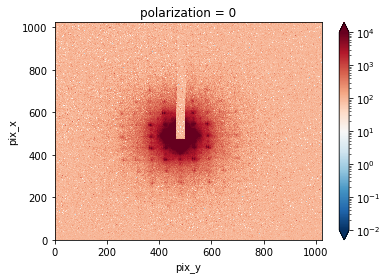

In [10]:
from matplotlib.colors import LogNorm

demo.sel(energy=280).plot(norm=LogNorm(1e-2,1e4))

In [6]:
data_idx = []

for i,x in enumerate(raw_stack):
    print(f'{i}: {x.sample_name} @ energy {float(np.min(x.energy))}, pol: {float(x.polarization[0])}')
    data_idx.append([i,x.sample_name,float(np.min(x.energy)),float(x.polarization[0])])
    
data_idx = pd.DataFrame(data_idx,columns=['num','sample','energy','pol'])

0: TPPD30G @ energy 270.0, pol: 90.0
1: TP30G @ energy 270.0, pol: 0.0
2: TP100F @ energy 270.0, pol: 0.0
3: TPPD30F @ energy 270.0, pol: 90.0
4: TO30G @ energy 270.0, pol: 90.0
5: TP30F @ energy 270.0, pol: 0.0
6: TPPD30G @ energy 270.0, pol: 0.0
7: TP100F @ energy 270.0, pol: 0.0
8: TP30F @ energy 270.0, pol: 90.0
9: TO30F @ energy 270.0, pol: 0.0
10: TP30F @ energy 510.0, pol: 90.0
11: TP30F @ energy 510.0, pol: 0.0
12: TO30G @ energy 510.0, pol: 90.0
13: TP30G @ energy 510.0, pol: 0.0
14: TM30G @ energy 510.0, pol: 90.0
15: TPPD30G @ energy 510.0, pol: 0.0
16: TM30G @ energy 270.0, pol: 90.0
17: TO30F @ energy 510.0, pol: 0.0
18: TPPD30G @ energy 510.0, pol: 90.0
19: TP100F @ energy 510.0, pol: 0.0
20: TPPD30F @ energy 510.0, pol: 90.0
21: TM30F @ energy 270.0, pol: 90.0
22: TPPD30F @ energy 270.0, pol: 0.0
23: TO30G @ energy 270.0, pol: 0.0
24: TP30G @ energy 270.0, pol: 90.0
25: TP100F @ energy 270.0, pol: 90.0
26: TP100G @ energy 270.0, pol: 0.0
27: TM30F @ energy 270.0, pol: 0.

In [7]:
reduction_stack = []

for i,f in enumerate(data_idx.groupby('energy')):
    templist = []
    for idx in f[1].num:
        print(idx)
        templist.append(raw_stack[idx])
    reduction_stack.append(templist)
reduction_stack

0
1
2
3
4
5
6
7
8
9
16
21
22
23
24
25
26
27
28
29
30
10
11
12
13
14
15
17
18
19
20
31
32
33
34
35
36
37
38
39
40


[[<xarray.DataArray (system: 61, pix_x: 1024, pix_y: 1026)>
  array([[[107, 149, 115, ..., 114, 124, 102],
          [ 95, 110,  96, ..., 112,  90, 105],
          [119, 130,  99, ..., 113, 149,  82],
          ...,
          [177, 126,  98, ..., 117, 120,  99],
          [150, 138, 167, ..., 106,  82, 102],
          [171, 137,  97, ..., 205,  86, 154]],
  
         [[ 98, 108, 120, ...,  98, 112,  96],
          [114, 103, 101, ..., 108, 109, 124],
          [115, 116, 112, ..., 133, 105,  79],
          ...,
          [102, 163, 110, ...,  93, 108, 108],
          [113,  97,  99, ..., 169,  75, 111],
          [108, 138, 118, ..., 124, 137, 120]],
  
         [[137, 116, 243, ..., 215, 129, 102],
          [144, 140, 258, ..., 220,  85,  89],
          [195, 110, 193, ..., 273, 140, 266],
          ...,
  ...
          ...,
          [ 94, 122, 125, ..., 189, 107,  87],
          [104, 151, 122, ..., 133, 102, 139],
          [133, 136, 129, ..., 215,  94, 186]],
  
         [[124, 

In [11]:
#integrate these...

integrator = PFEnergySeriesIntegrator(maskmethod = "none",
                                 geomethod = "template_xr",
                                 template_xr = demo,
                                 correctSolidAngle=True,
                                 integration_method='csr') # add ocl to run in opencl
integrator.mask = np.zeros([1024,1026])
print('Set up integration')
#int_stack = []
#for img in raw_stack:
#    int_stack.append(integrator.integrateImageStack(img))
int_demo = integrator.integrateImageStack(demo)

Set up integration


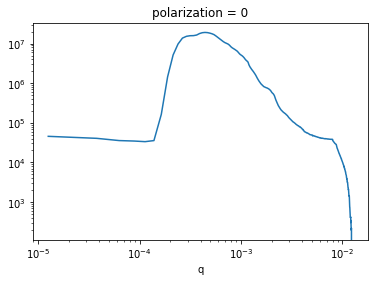

In [18]:
int_demo.sel(energy=280).sum('chi').plot(xscale='log',yscale='log')

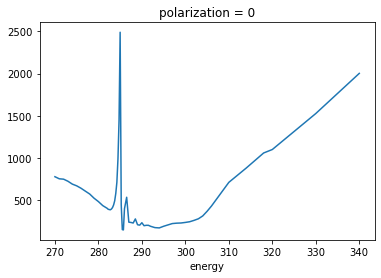

In [24]:
int_demo.sel(chi=slice(-5,5)).mean('chi').unstack('system').sel(q=slice(0.002,0.003)).mean('q').plot()#norm=LogNorm(1e-2,1e4))

In [28]:
sel = int_demo#sel(q=slice(0.0005,0.001)).unstack('system').mean('q')

(array([1.0411217e+07, 1.6164300e+05, 7.6162000e+04, 4.6681000e+04,
        3.2854000e+04, 3.6363000e+04, 6.0451000e+04, 1.0664000e+04,
        7.7740000e+03, 1.5510000e+03]),
 array([  -671.7925734 ,  14848.47867522,  30368.74992384,  45889.02117246,
         61409.29242109,  76929.56366971,  92449.83491833, 107970.10616695,
        123490.37741557, 139010.64866419, 154530.91991281]),
 <BarContainer object of 10 artists>)

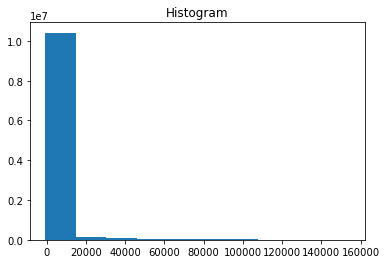

In [29]:
sel.plot()

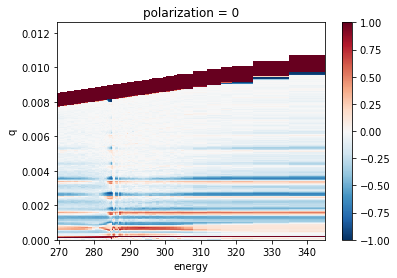

In [31]:
para = sel.sel(chi=slice(-5,5)).mean('chi') 
perp = sel.sel(chi=slice(-95,-85)).mean('chi')
ar = (para - perp) / (para+perp)
ar.unstack('system').plot()

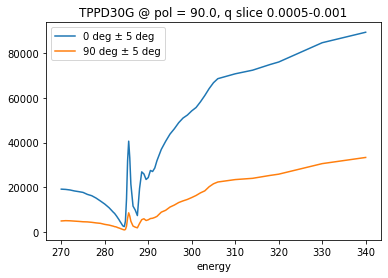

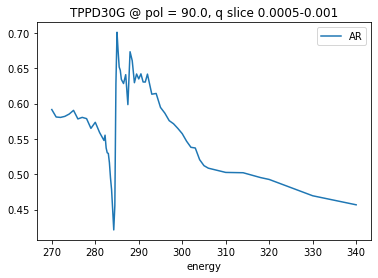

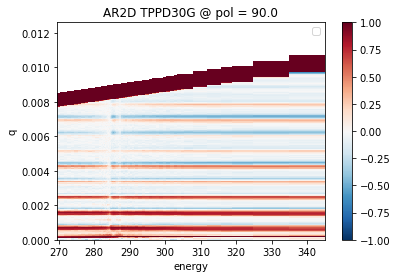

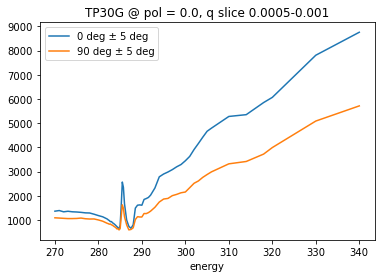

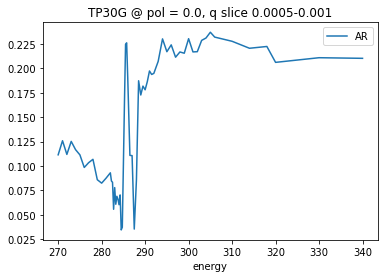

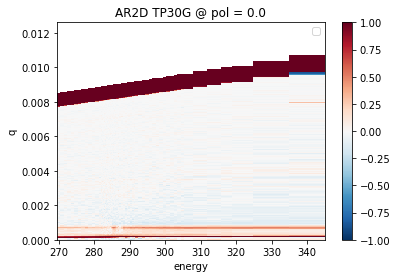

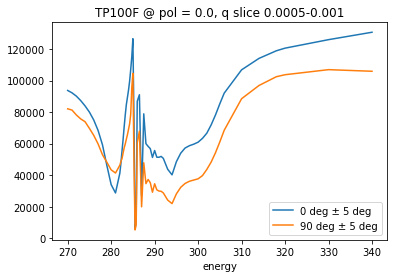

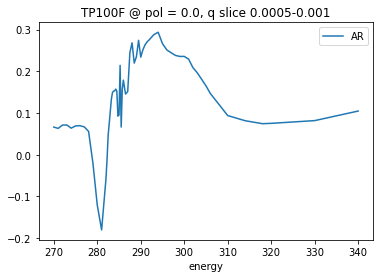

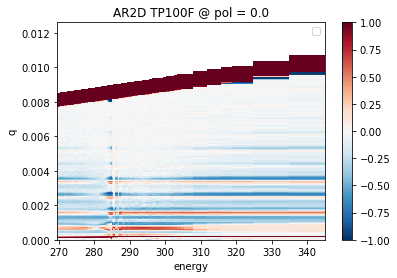

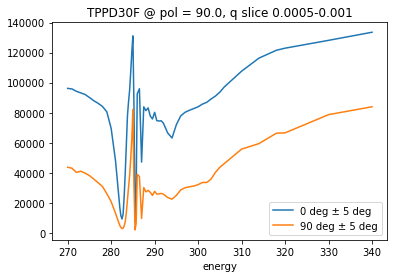

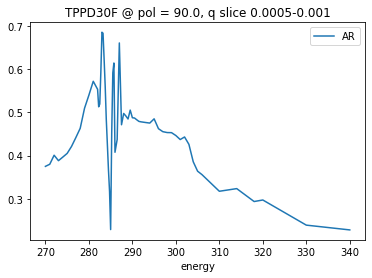

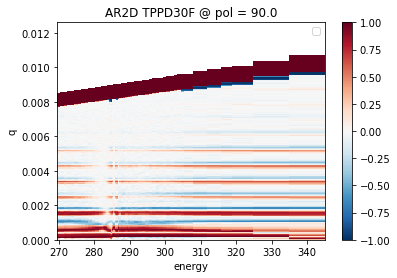

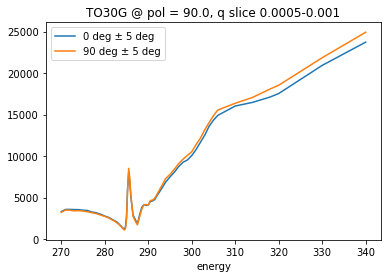

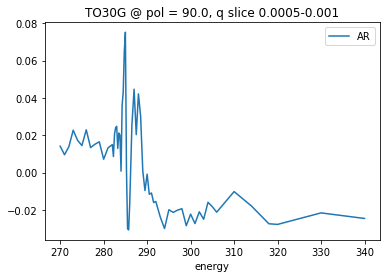

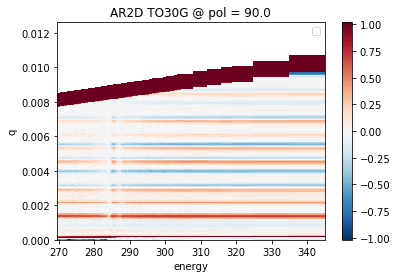

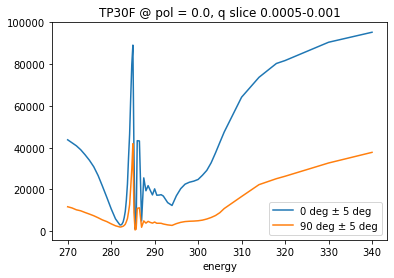

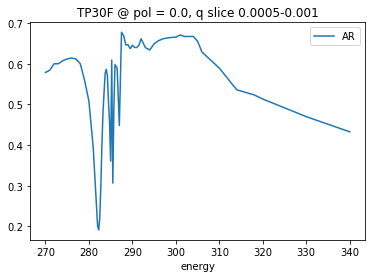

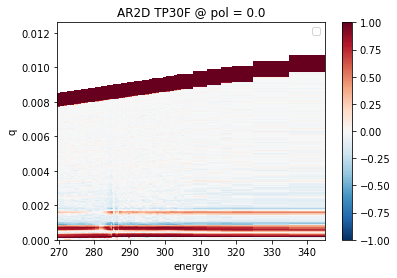

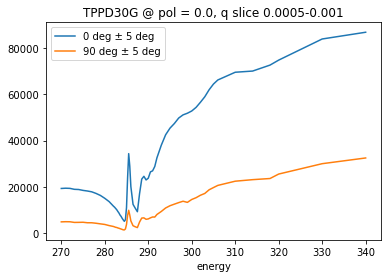

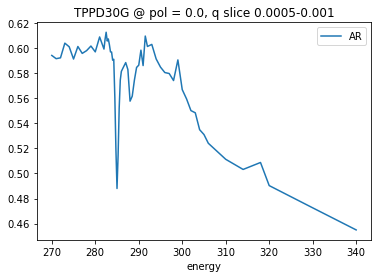

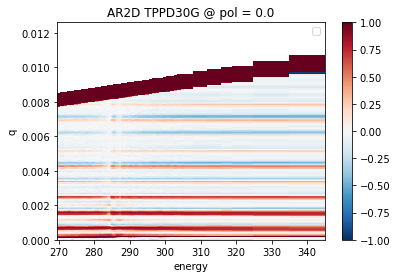

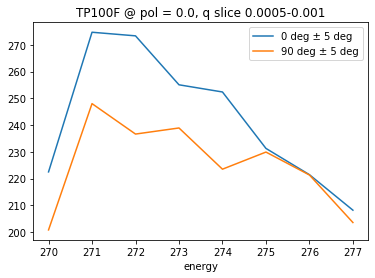

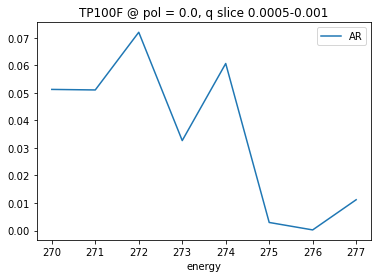

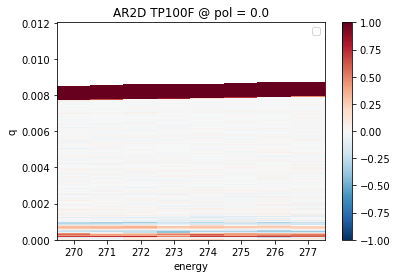

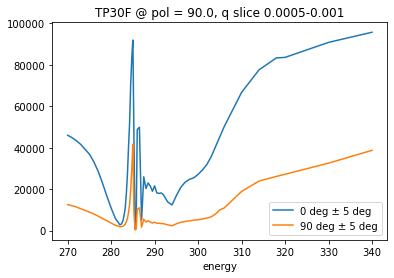

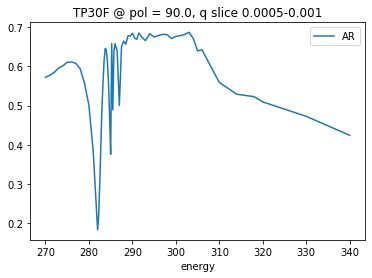

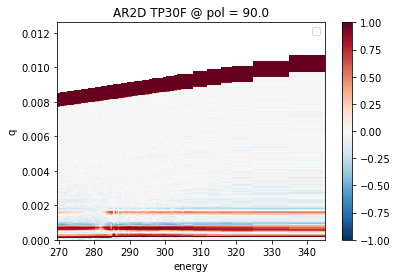

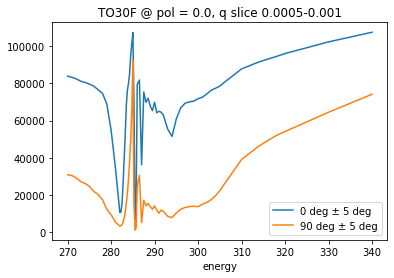

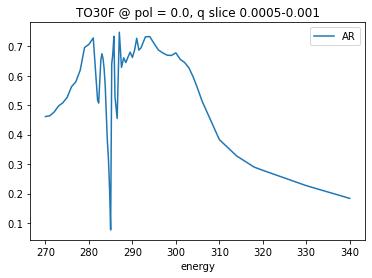

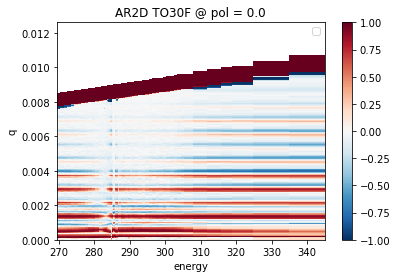

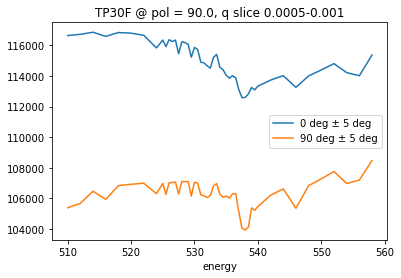

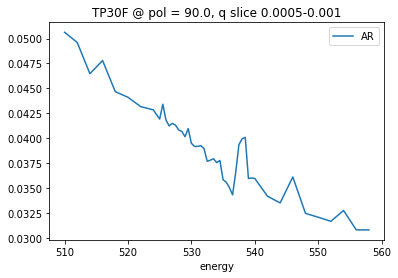

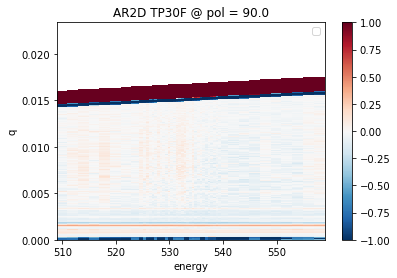

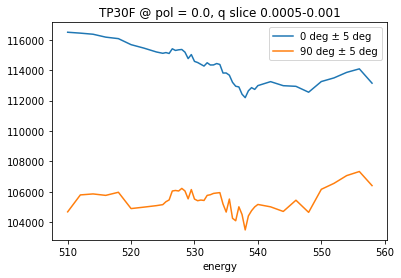

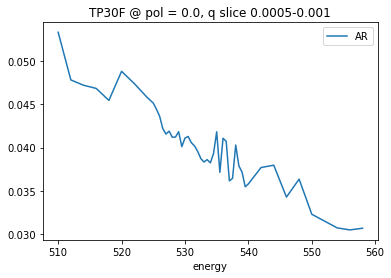

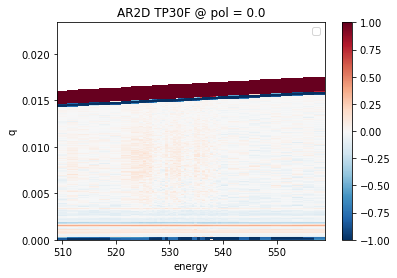

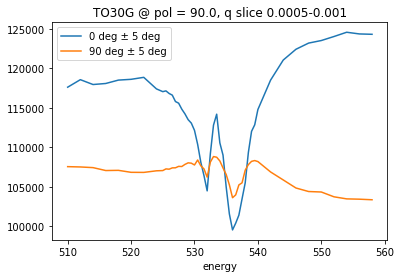

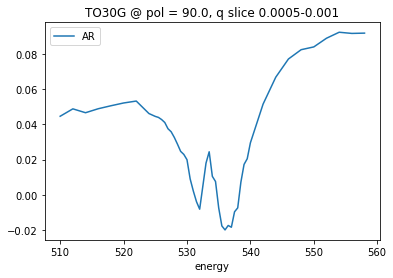

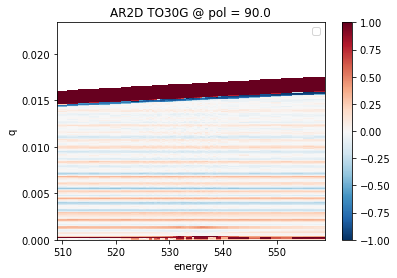

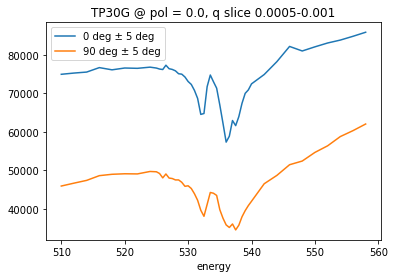

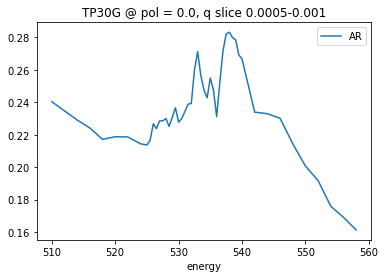

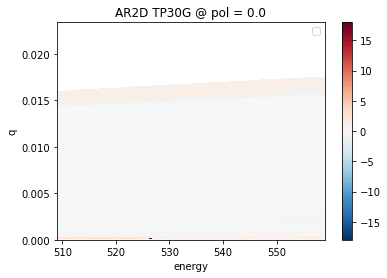

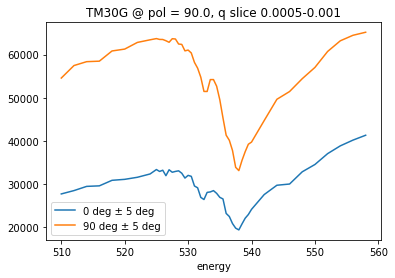

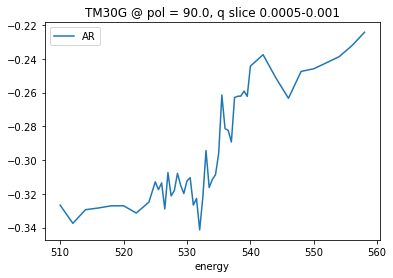

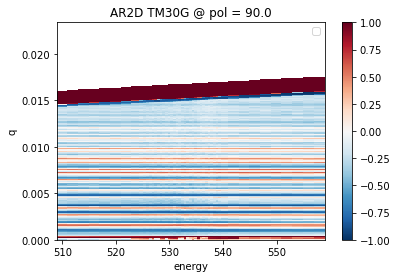

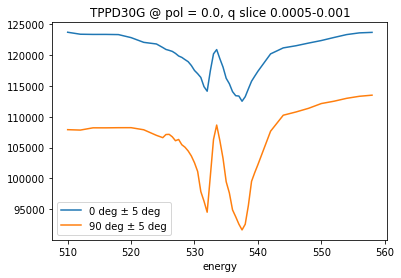

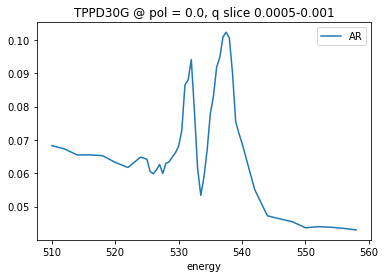

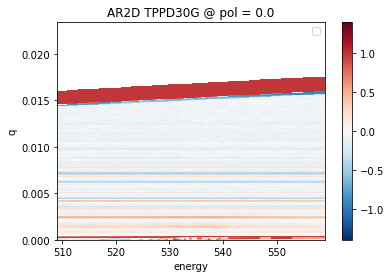

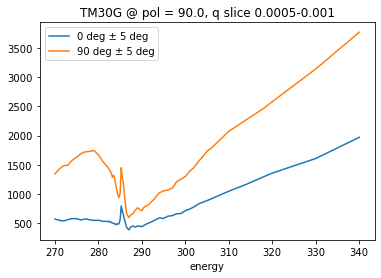

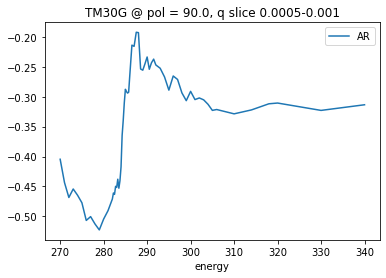

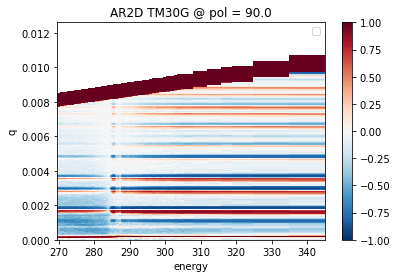

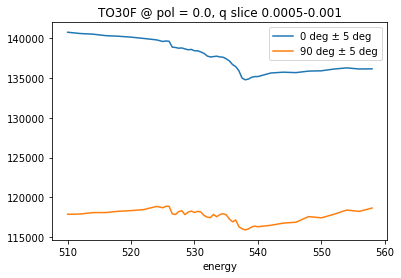

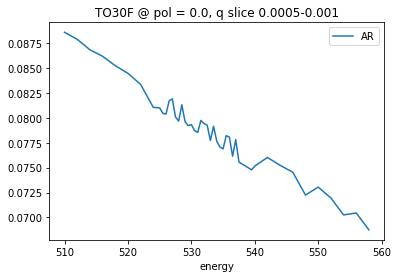

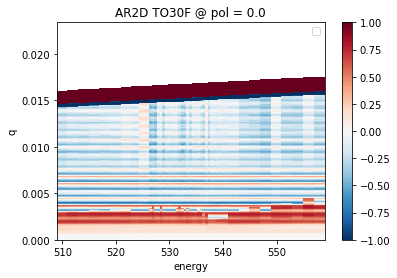

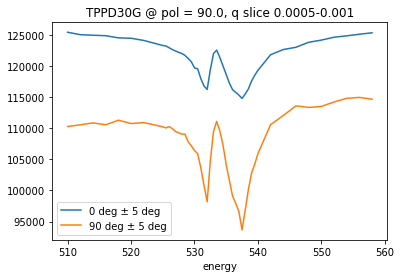

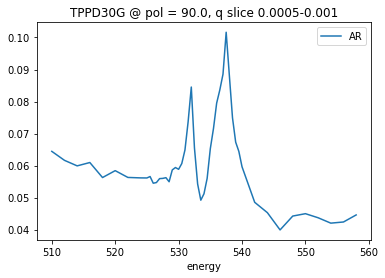

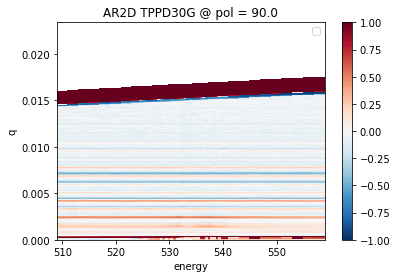

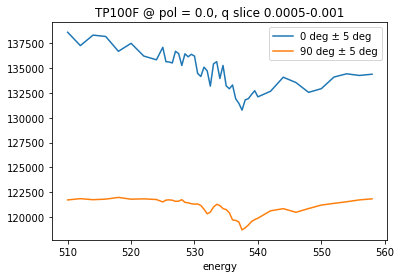

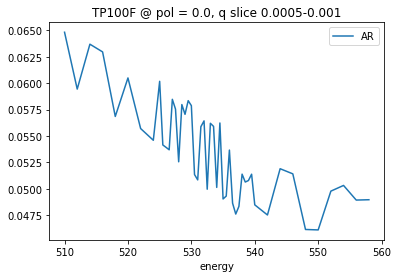

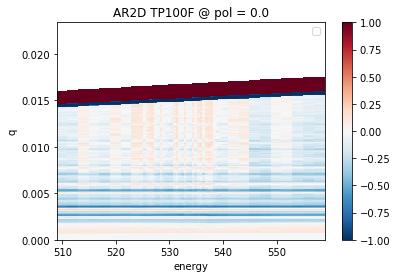

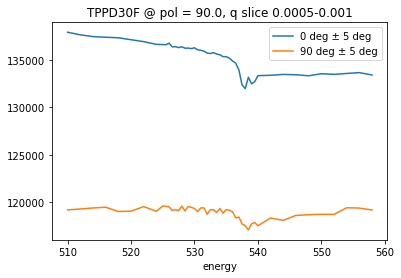

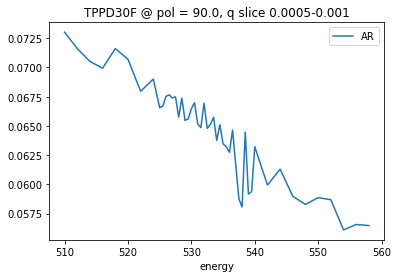

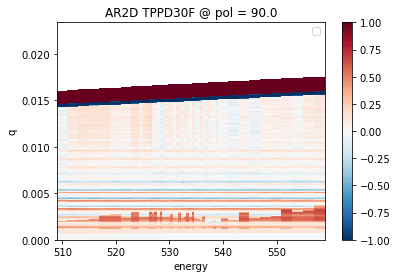

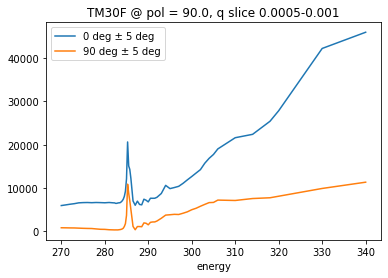

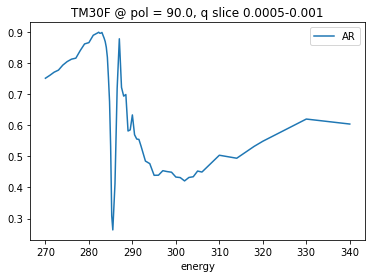

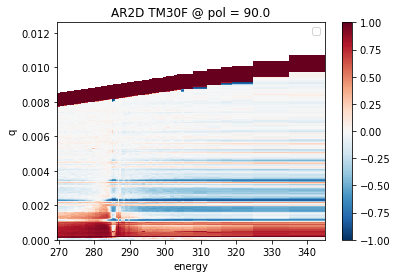

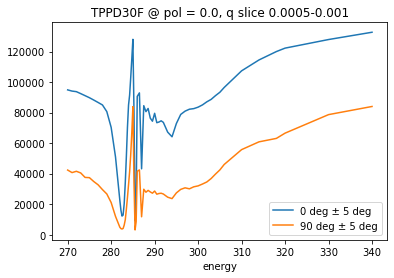

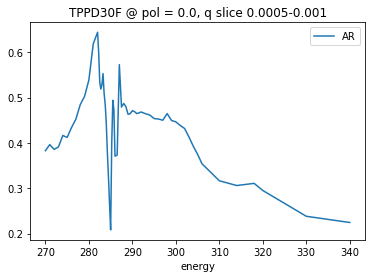

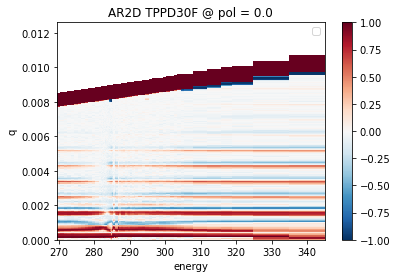

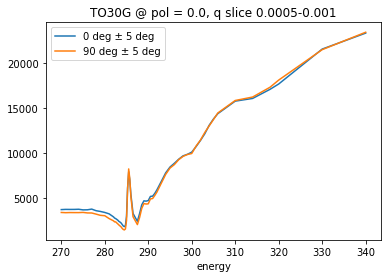

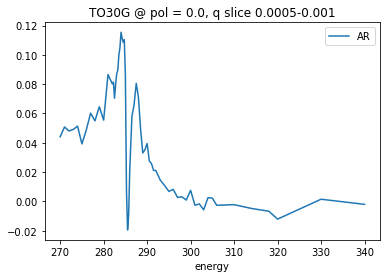

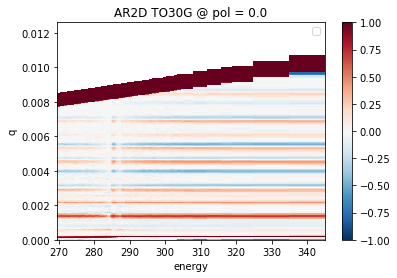

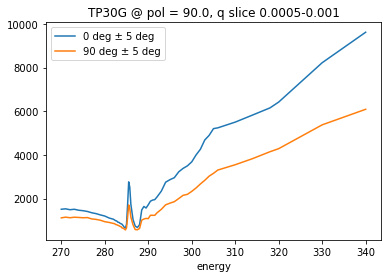

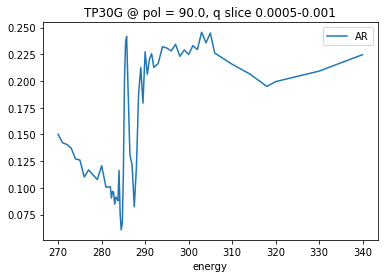

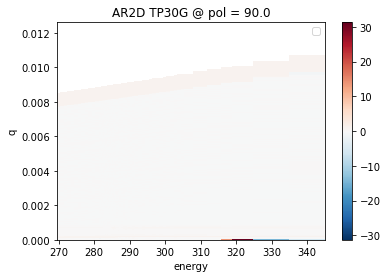

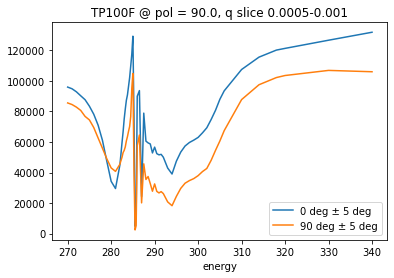

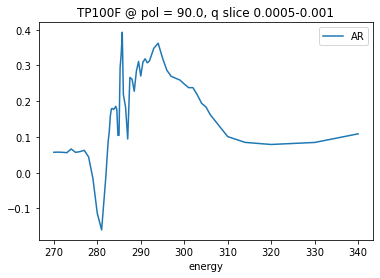

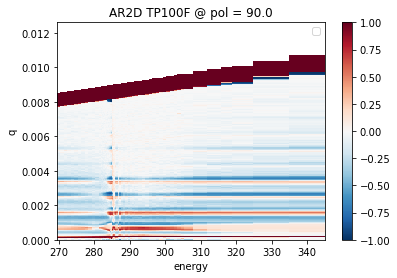

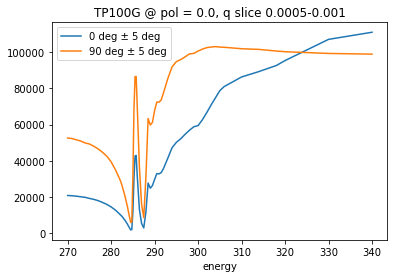

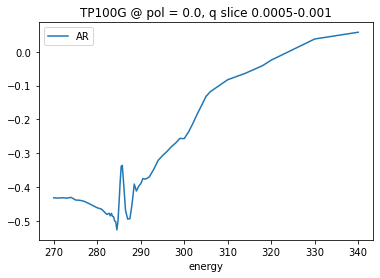

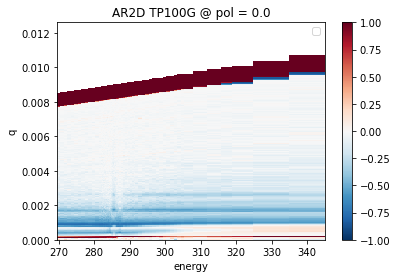

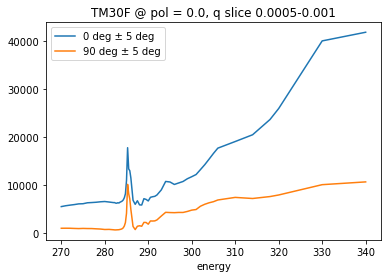

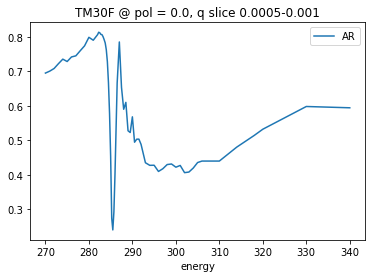

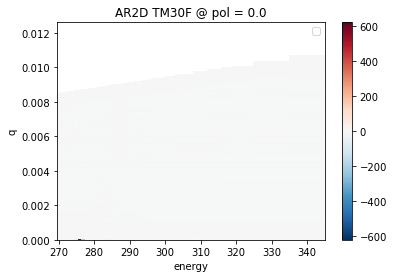

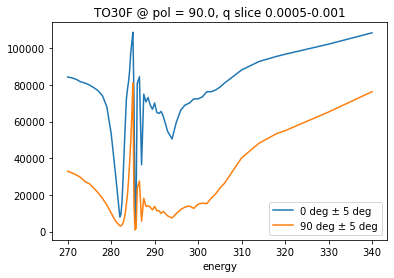

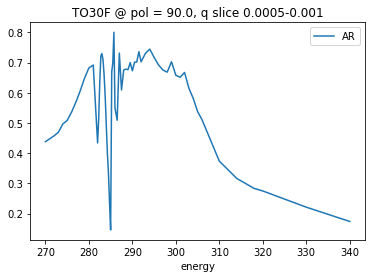

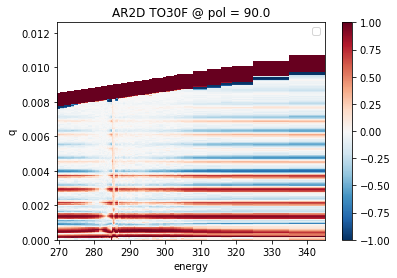

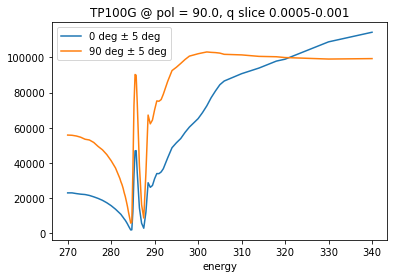

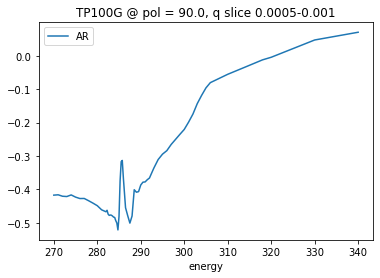

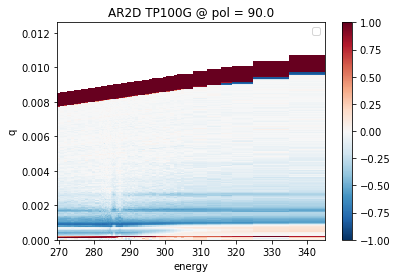

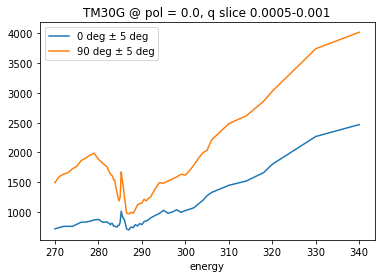

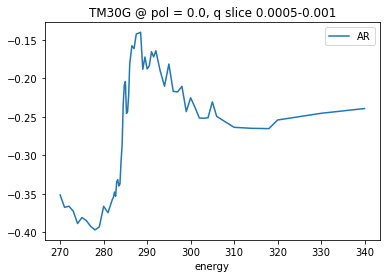

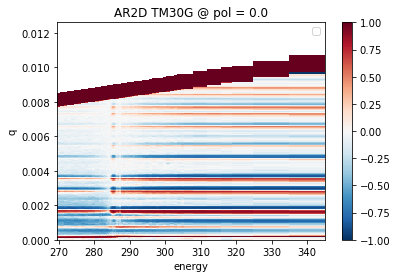

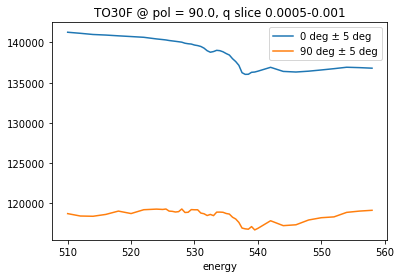

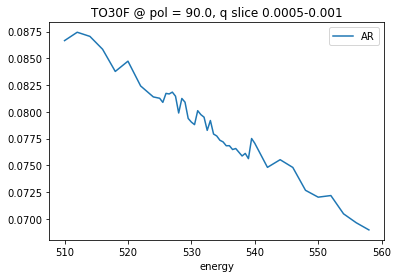

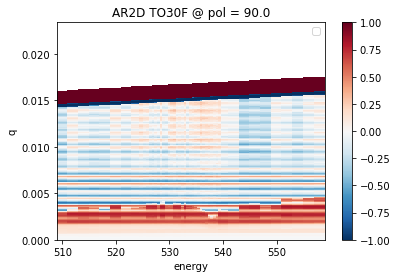

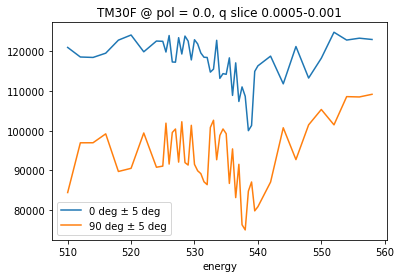

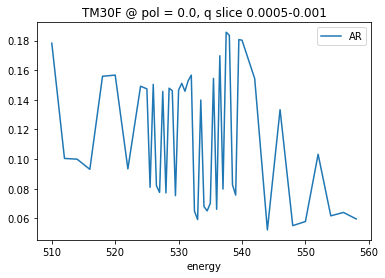

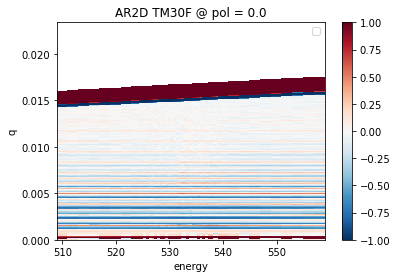

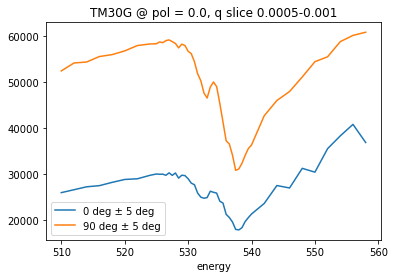

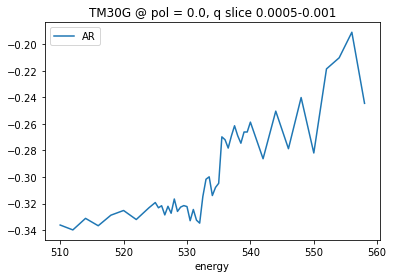

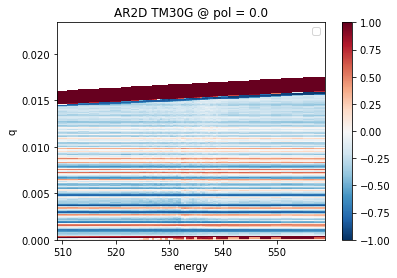

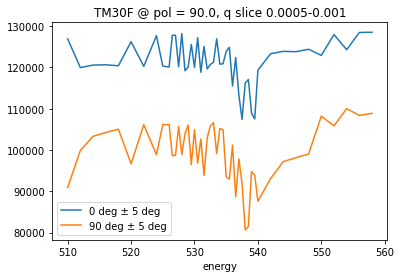

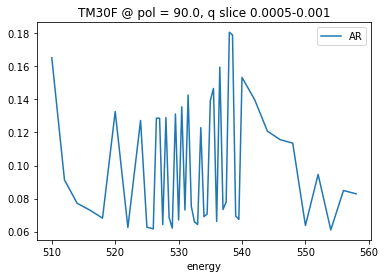

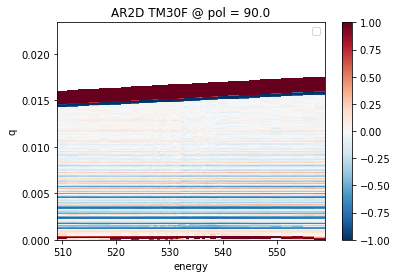

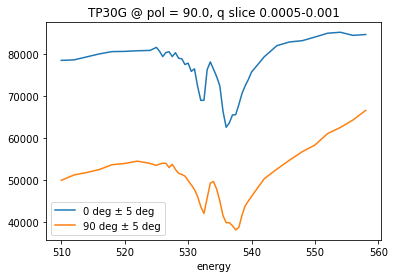

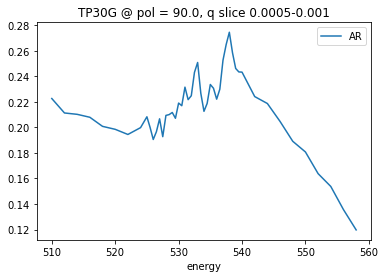

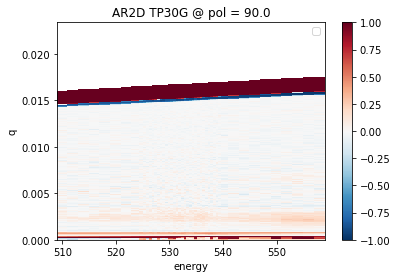

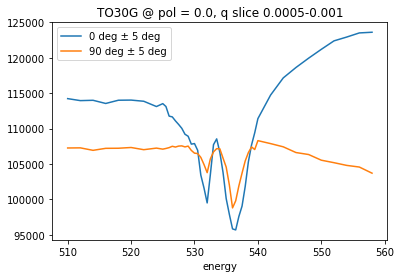

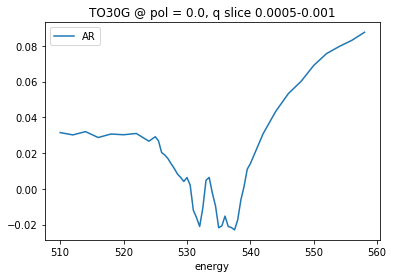

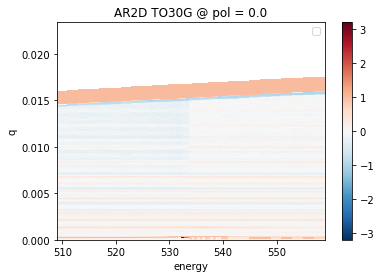

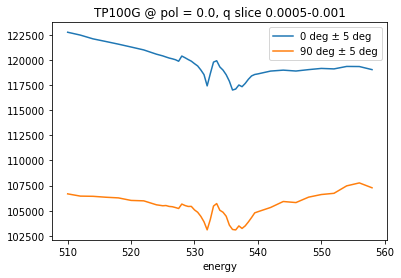

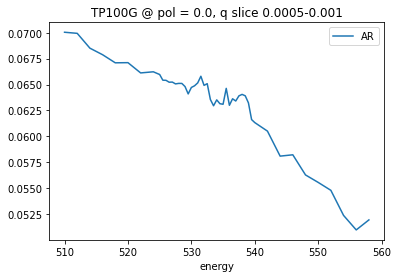

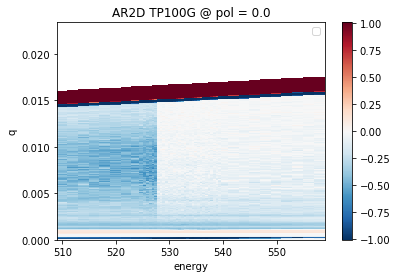

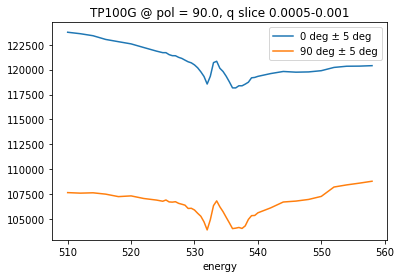

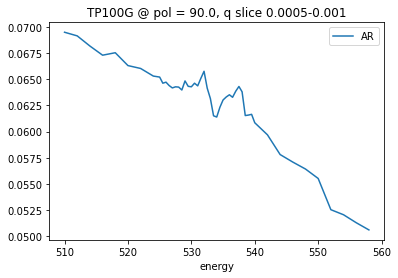

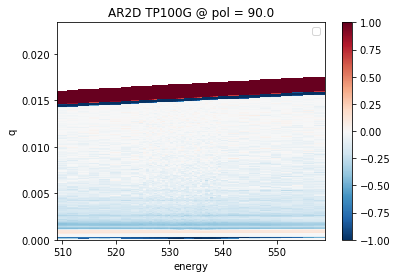

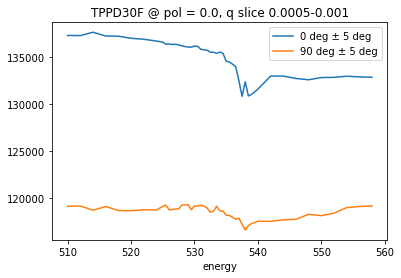

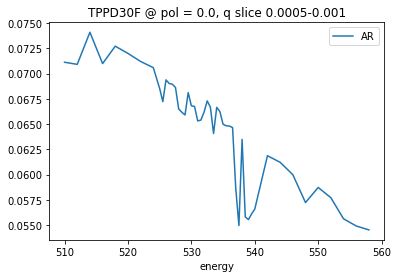

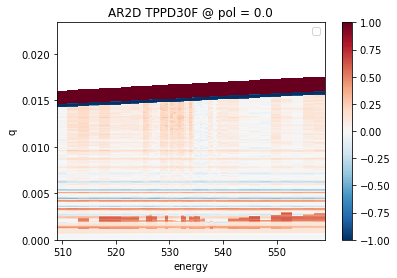

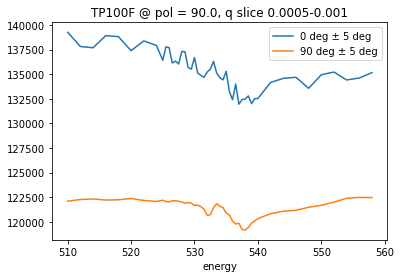

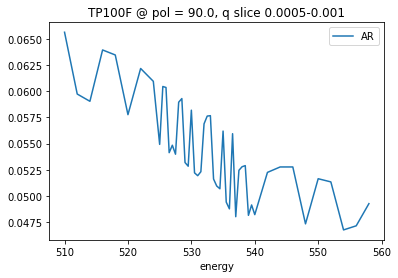

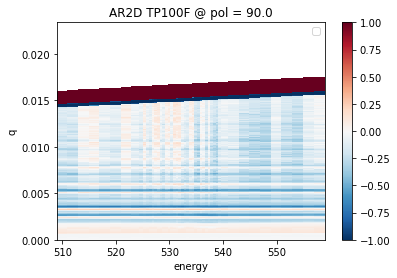

In [11]:
from matplotlib.colors import LogNorm
#int_stack[0].sel(energy=270).plot(norm=LogNorm(1e1,1e5))
for img in int_stack:
    f = plt.figure()

    img.sel(chi=slice(-5,5),q=slice(0.0005,0.001)).unstack('system').mean('chi').mean('q').plot(label='0 deg ± 5 deg')#norm=LogNorm(1e1,1e5))
    img.sel(chi=slice(-95,-85),q=slice(0.0005,0.001)).unstack('system').mean('chi').mean('q').plot(label='90 deg ± 5 deg')#norm=LogNorm(1e1,1e5))
    plt.title(f'{img.sample_name} @ pol = {float(img.polarization[0])}, q slice 0.0005-0.001')
    plt.legend()
    plt.show()
    plt.savefig(f'INT_{img.sample_name}pol{float(img.polarization[0])}q0.0005-0.001.png')
    plt.close()
    f = plt.figure()
    sel = img.sel(q=slice(0.0005,0.001)).unstack('system').mean('q')
    para = sel.sel(chi=slice(-5,5)).mean('chi') 
    perp = sel.sel(chi=slice(-95,-85)).mean('chi')
    ar = (para - perp) / (para+perp)
    
    ar.plot(label='AR')
    plt.title(f'{img.sample_name} @ pol = {float(img.polarization[0])}, q slice 0.0005-0.001')
    plt.legend()
    plt.show()
    plt.savefig(f'AR_{img.sample_name}pol{float(img.polarization[0])}q0.0005-0.001.png')
    plt.close()
    
    f = plt.figure()
    para = img.sel(chi=slice(-5,5)).mean('chi') 
    perp = img.sel(chi=slice(-95,-85)).mean('chi')
    ar = (para - perp) / (para+perp)
    
    ar.unstack('system').plot(label='AR2D')
    plt.title(f'AR2D {img.sample_name} @ pol = {float(img.polarization[0])}')
    plt.legend()
    plt.show()
    plt.savefig(f'AR2D_{img.sample_name}pol{float(img.polarization[0])}.png')
    plt.close() 


In [67]:
plt.close('all')

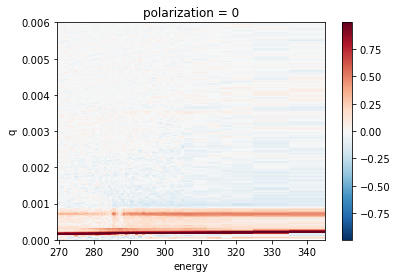

In [47]:
import RSoXS
RSoXS.AR(int_stack[1],chi_width=5).unstack('system').sel(q=slice(0,0.006)).plot()#sel(q=slice(0.0025,0.0035)).mean('q').plot()

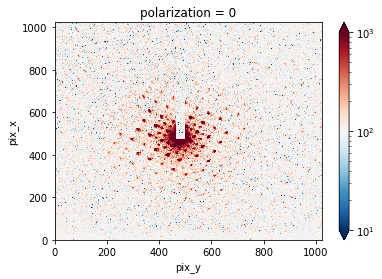

In [64]:
raw_stack[30].sel(energy=284.75,method='nearest').plot(norm=LogNorm(10,1e3))

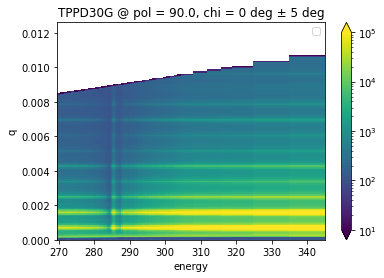

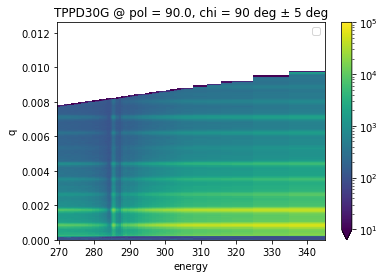

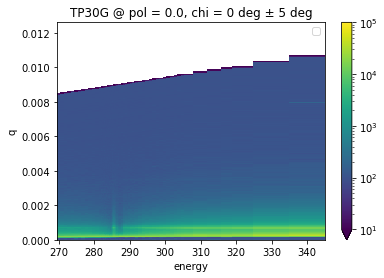

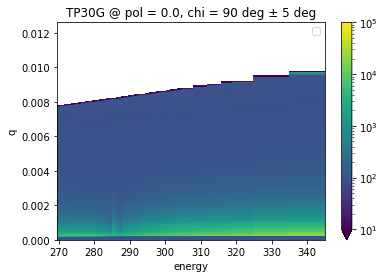

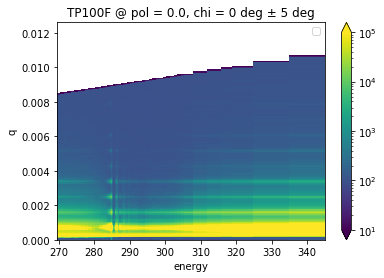

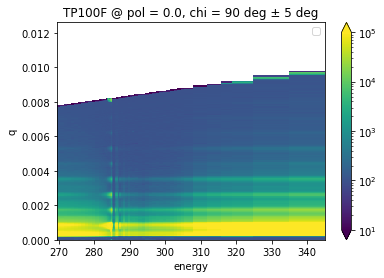

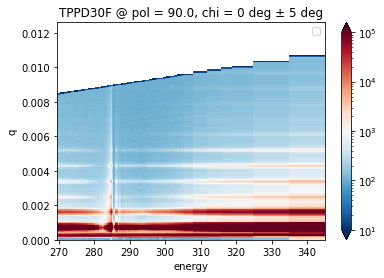

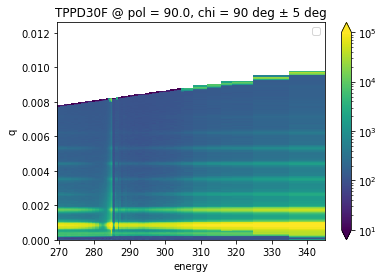

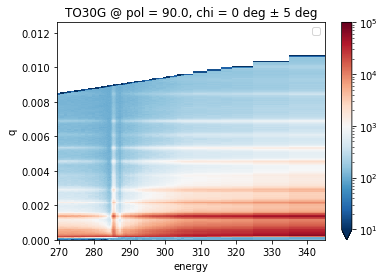

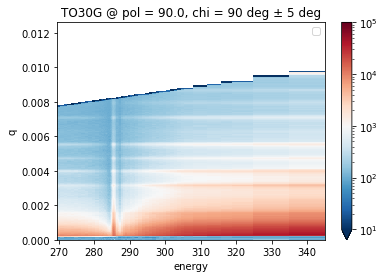

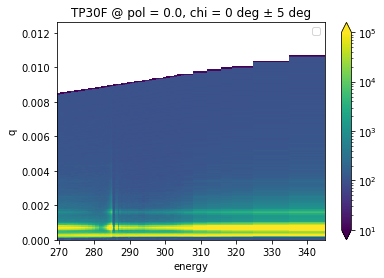

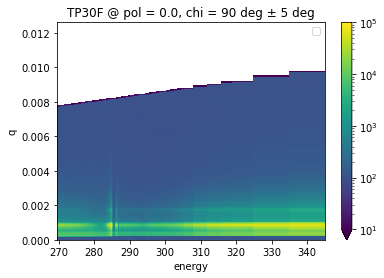

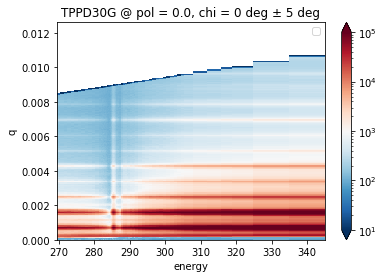

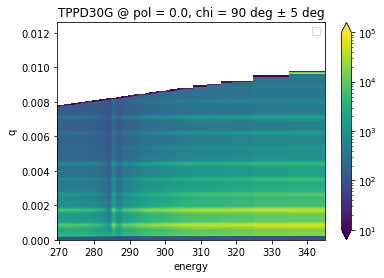

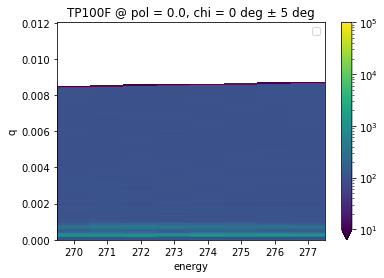

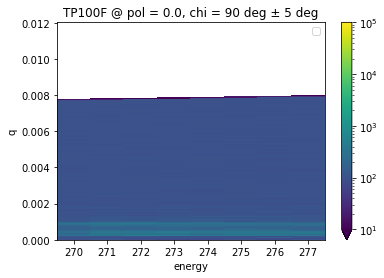

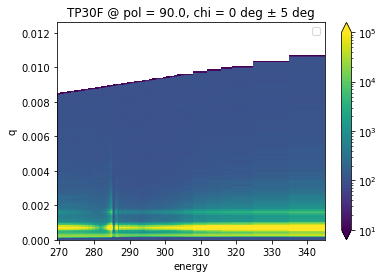

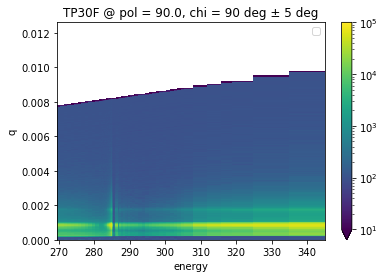

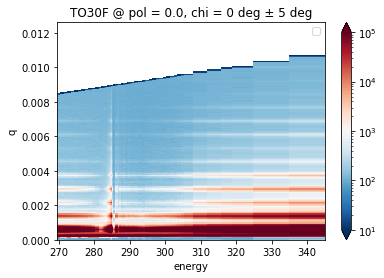

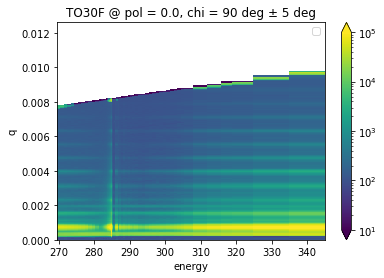

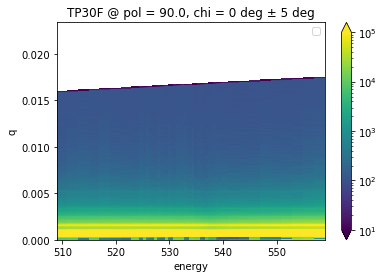

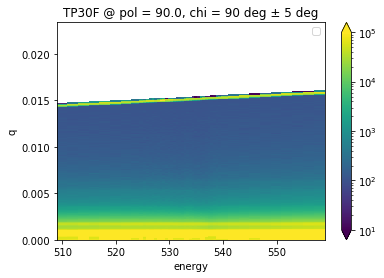

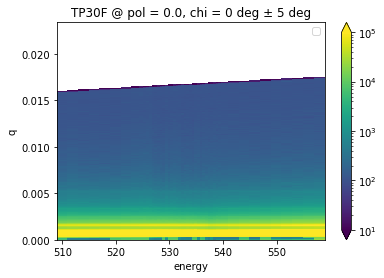

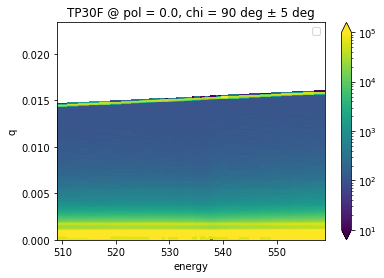

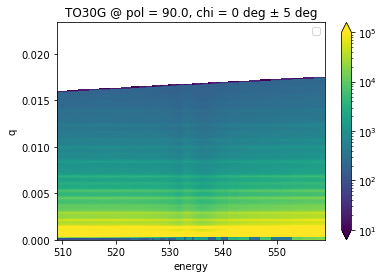

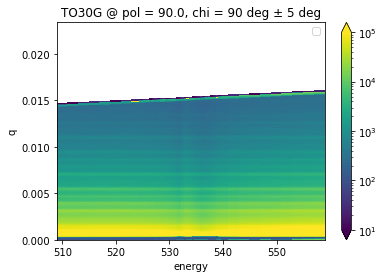

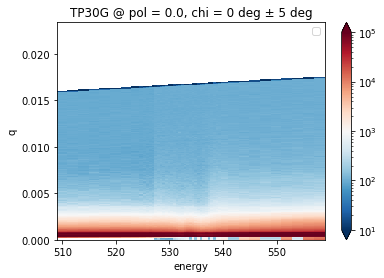

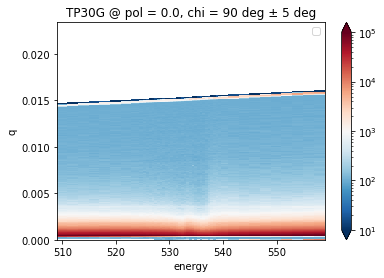

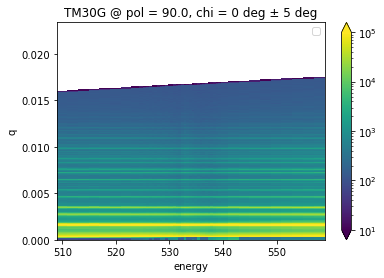

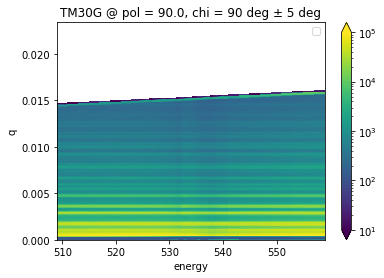

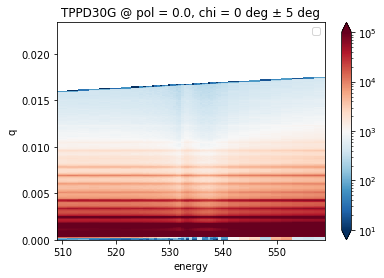

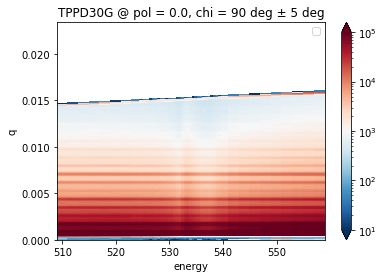

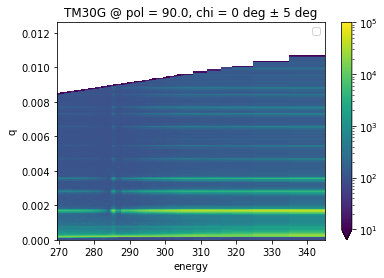

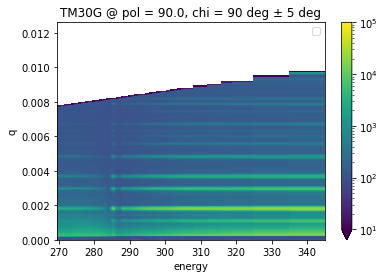

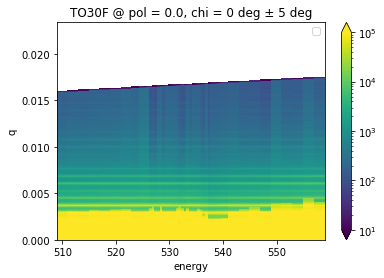

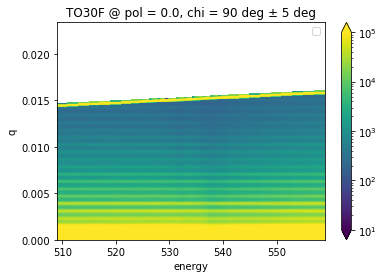

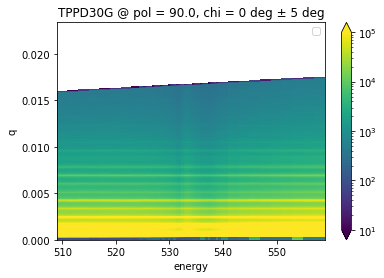

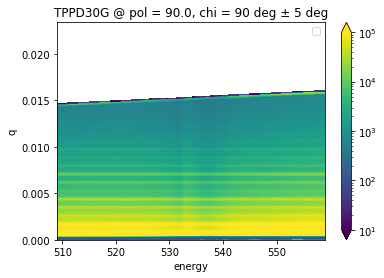

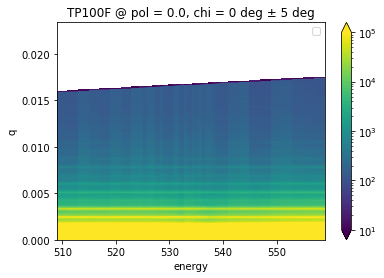

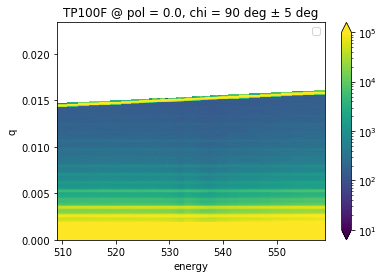

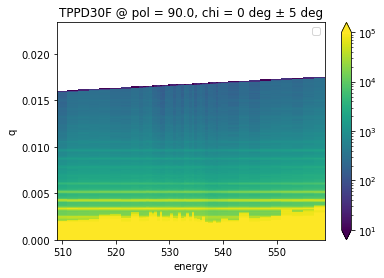

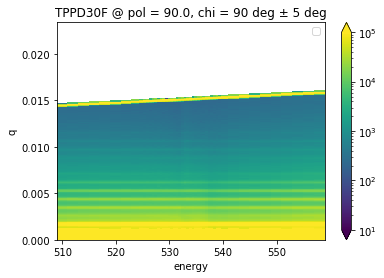

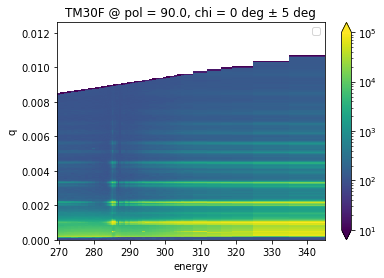

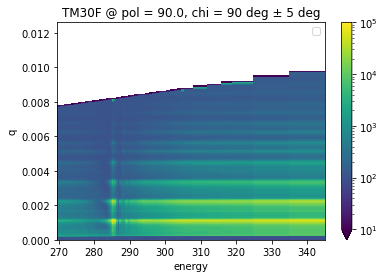

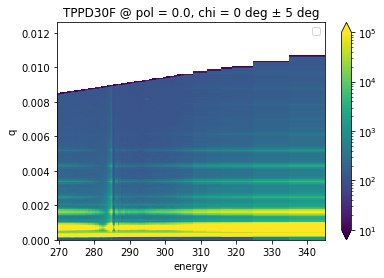

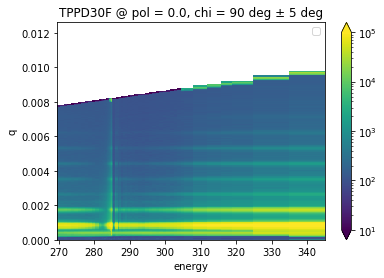

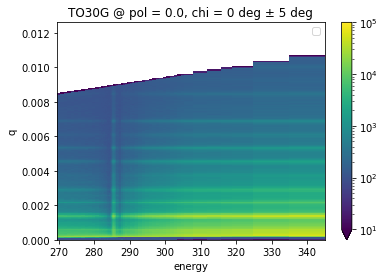

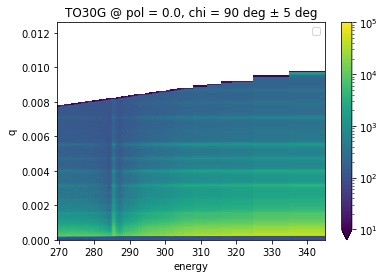

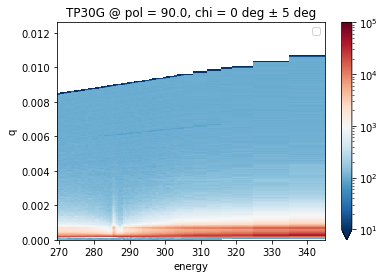

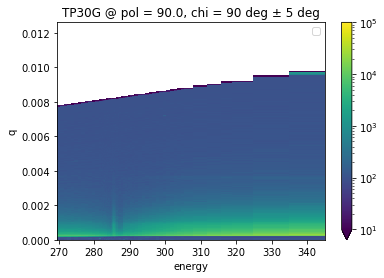

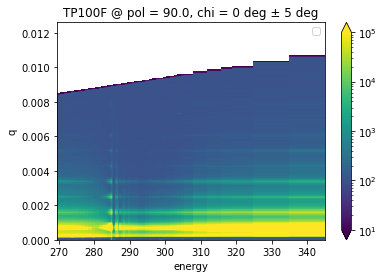

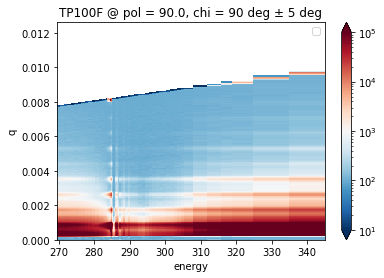

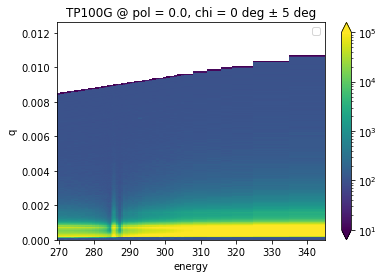

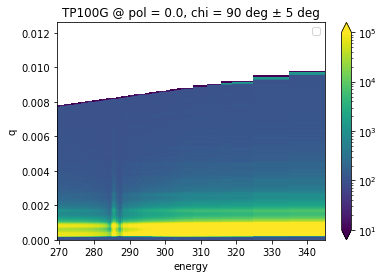

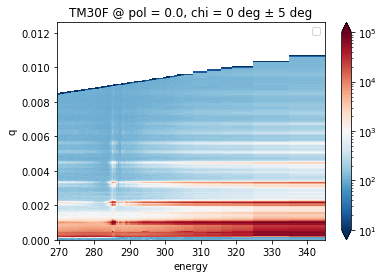

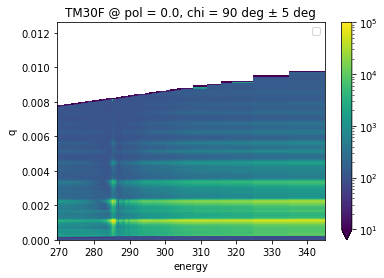

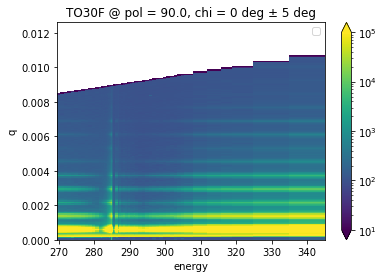

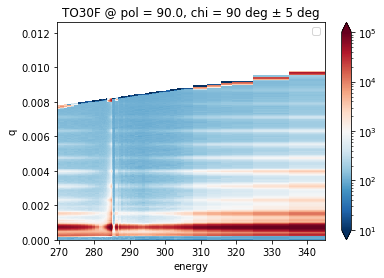

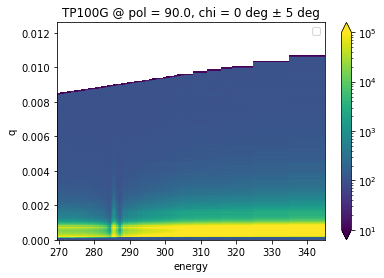

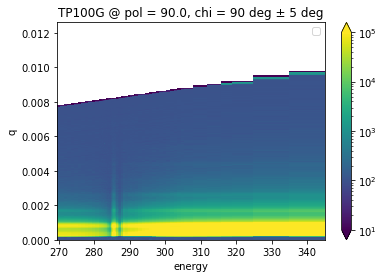

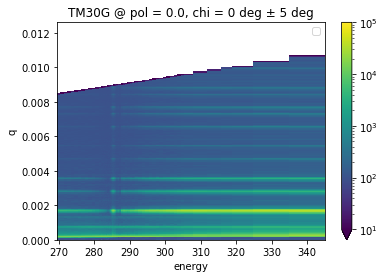

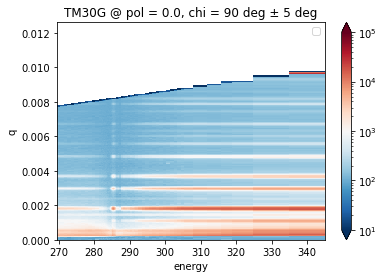

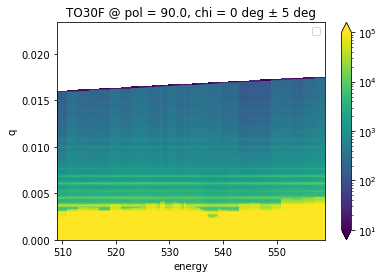

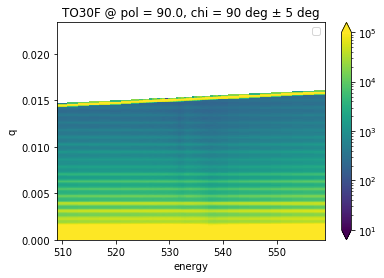

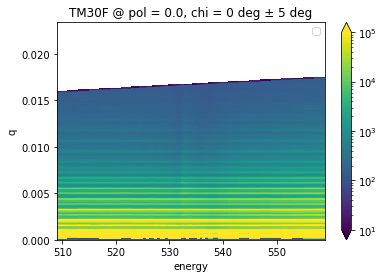

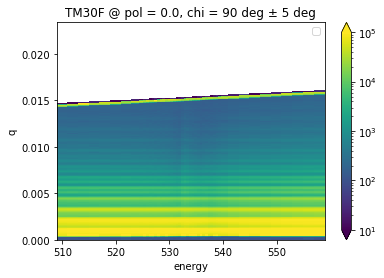

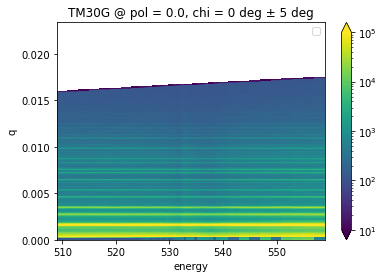

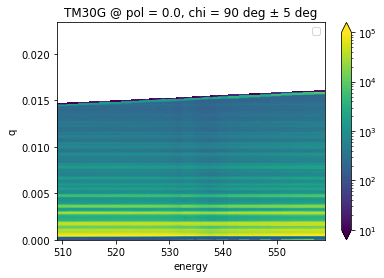

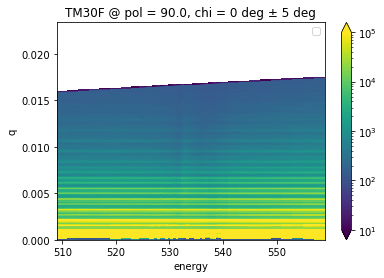

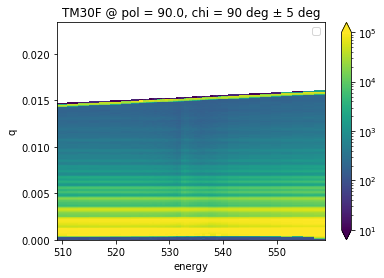

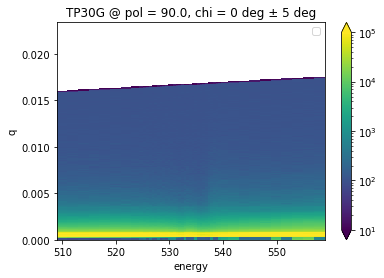

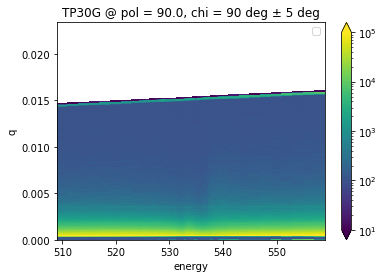

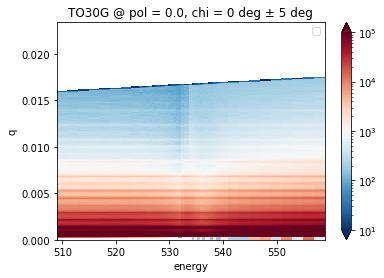

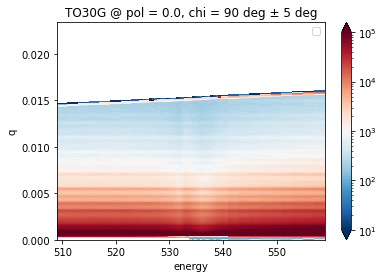

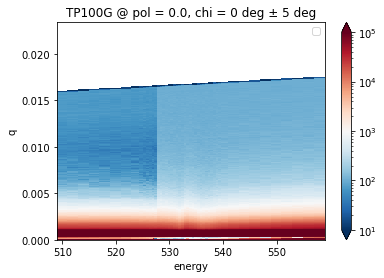

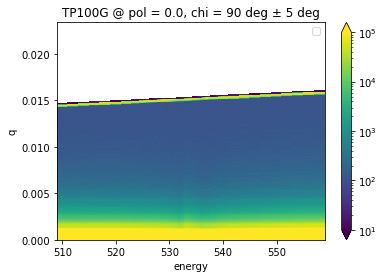

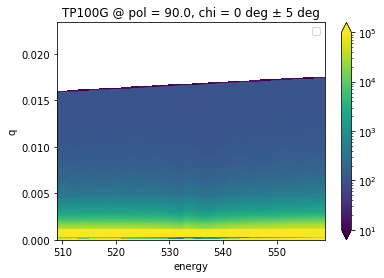

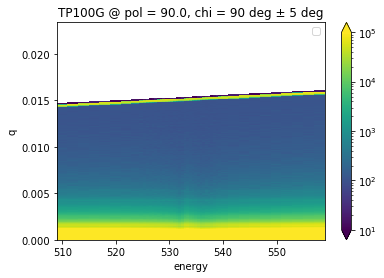

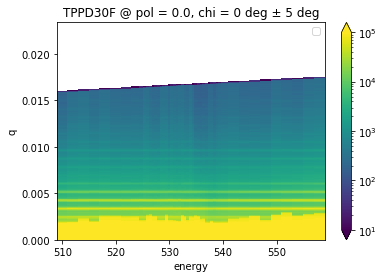

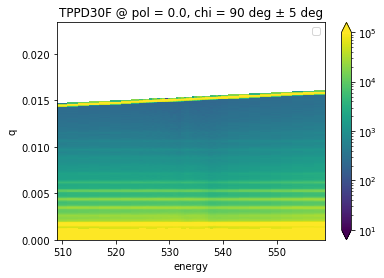

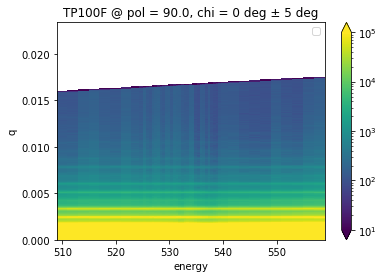

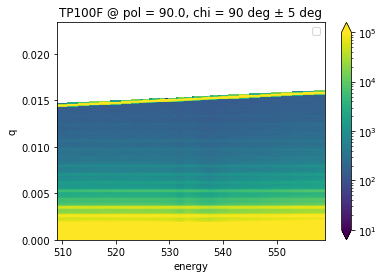

In [68]:
from matplotlib.colors import LogNorm
#int_stack[0].sel(energy=270).plot(norm=LogNorm(1e1,1e5))
for img in int_stack:
    f = plt.figure()

    img.sel(chi=slice(-5,5)).unstack('system').mean('chi').plot(label='0 deg ± 5 deg',norm=LogNorm(1e1,1e5))
    plt.title(f'{img.sample_name} @ pol = {float(img.polarization[0])}, chi = 0 deg ± 5 deg')
    plt.legend()
    plt.show()
    plt.savefig(f'2D_chi0_{img.sample_name}_pol{float(img.polarization[0])}.png')
    plt.close()
    img.sel(chi=slice(-95,-85)).unstack('system').mean('chi').plot(label='90 deg ± 5 deg',norm=LogNorm(1e1,1e5))
    plt.title(f'{img.sample_name} @ pol = {float(img.polarization[0])}, chi = 90 deg ± 5 deg')
    plt.legend()
    plt.show()
    plt.savefig(f'2D_chi90_{img.sample_name}_pol{float(img.polarization[0])}.png')
    plt.close()




In [86]:
# OK, start to try to use both polarizations

for sam in data_idx.groupby('sample'):
    print(f'Processing for {sam[0]}')
    for enset in sam[1].groupby('energy'):
        print(f'    Processing energy group {enset[0]}')
        pol90 = enset[1][enset[1]['pol']==90.0].num
        pol0 = enset[1][enset[1]['pol']==0.0].num
        print(f'        Pol 0: {pol0}')
        print(f'        Pol 90: {pol90}')

Processing for TM30F
    Processing energy group 270.0
        Pol 0: 27    27
Name: num, dtype: int64
        Pol 90: 21    21
Name: num, dtype: int64
    Processing energy group 510.0
        Pol 0: 32    32
Name: num, dtype: int64
        Pol 90: 34    34
Name: num, dtype: int64
Processing for TM30G
    Processing energy group 270.0
        Pol 0: 30    30
Name: num, dtype: int64
        Pol 90: 16    16
Name: num, dtype: int64
    Processing energy group 510.0
        Pol 0: 33    33
Name: num, dtype: int64
        Pol 90: 14    14
Name: num, dtype: int64
Processing for TO30F
    Processing energy group 270.0
        Pol 0: 9    9
Name: num, dtype: int64
        Pol 90: 28    28
Name: num, dtype: int64
    Processing energy group 510.0
        Pol 0: 17    17
Name: num, dtype: int64
        Pol 90: 31    31
Name: num, dtype: int64
Processing for TO30G
    Processing energy group 270.0
        Pol 0: 23    23
Name: num, dtype: int64
        Pol 90: 4    4
Name: num, dtype: int64
   

Let's look at this xarray:

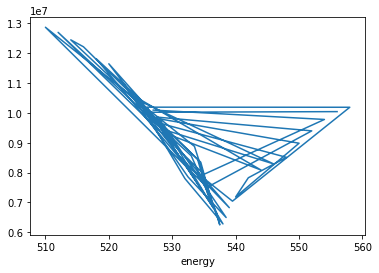

In [216]:
from matplotlib.colors import LogNorm
raw_xr.sel(pix_x=slice(350,400),pix_y=slice(350,400)).sum(['pix_x','pix_y']).plot(x='energy')

In [201]:
raw_xr.attrs

{'exposure': 2.0,
 'energy': 556.0,
 'polarization': 90,
 'sam_x': 9.0648,
 'sam_y': -179.9055,
 'sam_z': 0.0,
 'sam_th': 180.0,
 'rsoxs_config': 'saxs',
 'beamcenter_x': 489.86,
 'beamcenter_y': 490.75,
 'sdd': 521.8,
 'wavelength': 2.2299316546762593e-09,
 'seq_num': 46,
 'sampleid': '21792',
 'dist': 0.5217999999999999,
 'pixel1': 5.9999999999999995e-05,
 'pixel2': 5.9999999999999995e-05,
 'poni1': 0.029445,
 'poni2': 0.029391599999999997,
 'rot1': 0,
 'rot2': 0,
 'rot3': 0,
 'dims_unpacked': ['energy', 'polarization']}

In [202]:
raw_xr.energy

<xarray.DataArray 'energy' (system: 48)>
array([556. , 526.5, 536.5, 534.5, 514. , 516. , 534. , 536. , 526. , 558. ,
       539.5, 531.5, 518. , 525. , 544. , 529.5, 529. , 546. , 525.5, 520. ,
       531. , 539. , 530.5, 522. , 532.5, 538.5, 528.5, 548. , 542. , 540. ,
       550. , 528. , 538. , 532. , 524. , 530. , 527.5, 552. , 535.5, 510. ,
       533.5, 537.5, 537. , 533. , 512. , 535. , 554. , 527. ])
Coordinates:
  * system        (system) MultiIndex
  - energy        (system) float64 556.0 526.5 536.5 534.5 ... 535.0 554.0 527.0
  - polarization  (system) int64 90 90 90 90 90 90 90 ... 90 90 90 90 90 90 90

OK, let's try integrating this to get something useful!

We set up an integrator - the integrator supports calibrations from Nika and masks from Nika to make life easier.

In [203]:
integrator = PFEnergySeriesIntegrator(maskmethod = "none",
                                 geomethod = "template_xr",
                                 template_xr = raw_xr,
                                 correctSolidAngle=False,
                                 integration_method='csr') # add ocl to run in opencl
integrator.mask = np.zeros([1024,1026])

Let's take our test image from before and integrate it:

We can integrate a whole stack of images really easily:

Note, because we're using the energy series integrator, we're internally pre-allocating integrator objects for each energy then using those for each image for speed.  All these details are abstracted.

In [204]:
int_xr = integrator.integrateImageStack(raw_xr)

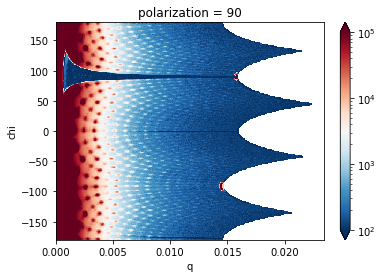

In [247]:
int_xr.sel(energy=510).plot(norm=LogNorm(1e2,1e5))

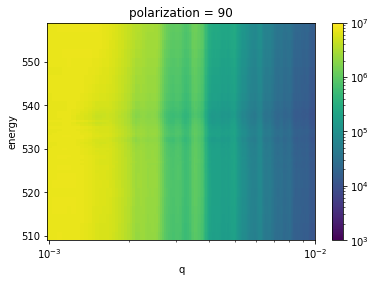

In [245]:
int_xr.sel(chi=slice(-50,0)).sum('chi').unstack('system').sel(q=slice(0.001,0.01)).plot.line(x='q',xscale='log')

In [17]:
integrator = None

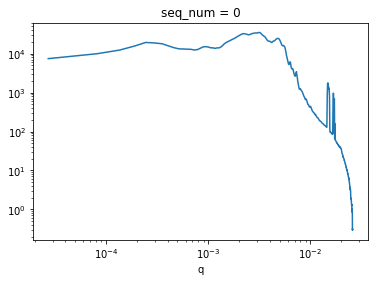

In [151]:
int_xr.sel(polarization=90,energy=510).mean('chi').plot(xscale='log',yscale='log')

In [58]:
import numpy as np
foo_hdr[1].coords['system'].values = foo_hdr[1].coords['system'].values[()][1][np.newaxis]


ValueError: replacement data must match the Variable's shape. replacement data has shape (1,); Variable has shape ()

In [65]:
raw_xr.coords['system'].values.ndim

1

In [55]:
foo_hdr[1].system

<xarray.DataArray 'system' ()>
array((190.0, 320.01), dtype=object)
Coordinates:
    system   object (190.0, 320.01)

In [145]:
int_hdr = integrator.integrateImageStack(raw_hdr)

AttributeError: 'DataArray' object has no attribute 'energy'

A side warning here: if you are using my example data, at this point the memory usage will be kind of insane (~20 GB peak, about 15.5 GB at rest).  We can clean up by tossing the raw data and integrator, which will take us down to something ~2 GB:

In [ ]:

integrator = None

As with the raw data, we can slice this using standard select commands, and even plot using the core xarray plotting.

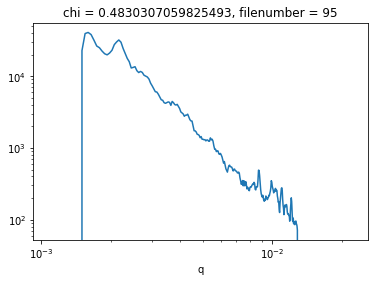

In [17]:
int_xr.sel(energy=270,polarization=100,exposure=1.002, chi=0,method='nearest').plot(xscale='log',yscale='log')

We can use slicing to punch out energy scans, for example: (this gets a little gross, probably I need an xarray cleanup function)

In [18]:
pol100chi0 = int_xr.sel(polarization=100,chi=0,method='nearest')
pol100chi0

<xarray.DataArray (system: 92, q: 500)>
array([[nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * q           (q) float64 2.377e-05 7.132e-05 0.0001189 ... 0.0237 0.02375
    chi         float64 0.483
  * system      (system) MultiIndex
  - energy      (system) float64 310.0 289.5 282.8 284.8 ... 284.0 286.0 280.0
  - exposure    (system) float64 1.002 1.002 0.003 0.102 ... 0.102 0.102 0.003
  - filenumber  (system) int64 92 84 10 47 51 6 71 26 ... 91 29 68 87 13 44 52 5
Attributes:
    SIMPLE:                         True
    BITPIX:                         8
    NAXIS:                          0
    EXTEND:                         True
    COMMENT:                            and Astrophysics', volume 376, page 3...
    EXPOSURE:                       1.0
    TEMP:                           -44.5
    RINGCRNT:                       500.060339355469
    DATE:                           2019-12-05T17:18:47
    ROI_L:                          1309
    ROI_T:                          526
    ROI_R:                          2539
    ROI_B:                          1627
    EPU Polarization:               100.0
    Coolstage Temp C:               0.0
    CCD Temperature:                -45.0
    Beam Current:                   500.132818603515
    TEY signal:                     -0.00136385642089821
    IZERO:                          -0.698759368088832
    Photodiode:                     -0.0174415487398088
    AI 0:                           0.0105281275274171
    AI 3 Izero:                     0.25842225556108
    AI 5:                           0.257279214499274
    AI 6 BeamStop:                  -35.2255056410498
    AI 7:                           -0.00296600067684033
    Temperature Controller:         0.0
    PZT Shutter:                    0.0
    Pause Trigger:                  0.0
    LV Memory:                      345552.0
    Time Stamp Error:               -0.0127792358398438
    Time Stamp Transmit Time:       1.27750742062926
    Time Stamp Server Time:         0.722492579370737
    Sample Azimuthal Rotation:      0.0
    Piezo Vertical:                 0.0
    Piezo Horiz:                    0.0
    Sample X:                       0.802
    Sample Y:                       -16.977
    Sample Z:                       -2.0
    Sample Theta:                   90.0
    Sample Y Scaled:                -15.9531616230824
    CCD Theta:                      -1.219
    Beam Stop:                      -10.447
    Pollux CCD X:                   0.0
    Pollux CCD Y:                   0.0
    CCD X:                          99.83
    CCD Y:                          100.0
    CCD Temperature Setpoint:       -45.0
    T-2T:                           90.0
    Beamline Energy:                309.999784281053
    Mono 101 Grating:               -36.1801606083782
    Beamline Energy Goal:           0.0
    Entrance Slit width:            35.0
    Exit Slit Left:                 3608.0
    Exit Slit Right:                8910.0
    Horizontal Exit Slit Size:      1500.0
    Horizontal Exit Slit Position:  -700.0
    Vertical Exit Slit Size:        25.9000000000001
    Vertical Exit Slit Position:    0.259999999999991
    EPU Gap:                        28.6995375
    EPU Z:                          -1.52587887711393e-09
    Mono Energy:                    309.999784281053
    M103 Yaw:                       2.205
    M103 Bend Up:                   0.5595
    M103 Bend Down:                 1.0033
    M101 Feedback:                  0.0
    M101 Horizontal Deflection:     2.002
    M101 Vertical Deflection:       -13.504
    Vertical Slit Position:         0.259999999999991
    Vertical Slit Size:             25.9000000000001
    Horizontal Slit Position:       -700.0
    Mono 101 Vessel:            

The one crude thing we have to do - remember that 'filenumber' axis we put in?  We need to get rid of it for auto-plotting to work... so we'll unstack the system multiindex (like a compound axis, done above) and select all values of the filenumber coordinate.  We also need to put the array in the right order for auto-plotting.

In [19]:
pol100chi0 = pol100chi0.sel(filenumber=slice(0,500)).sel(exposure=slice(0.08,0.11))
pol100chi0 = pol100chi0.drop('chi').sortby('energy').sortby('q')
pol100chi0

<xarray.DataArray (energy: 45, q: 500)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.],
       [nan, nan, nan, ...,  0.,  0.,  0.]])
Coordinates:
  * q        (q) float64 2.377e-05 7.132e-05 0.0001189 ... 0.0237 0.02375
  * energy   (energy) float64 270.0 270.0 280.0 281.0 ... 310.0 315.0 320.0
Attributes:
    SIMPLE:                         True
    BITPIX:                         8
    NAXIS:                          0
    EXTEND:                         True
    COMMENT:                            and Astrophysics', volume 376, page 3...
    EXPOSURE:                       1.0
    TEMP:                           -44.5
    RINGCRNT:                       500.060339355469
    DATE:                           2019-12-05T17:18:47
    ROI_L:                          1309
    ROI_T:                          526
    ROI_R:                          2539
    ROI_B:                          1627
    EPU Polarization:               100.0
    Coolstage Temp C:               0.0
    CCD Temperature:                -45.0
    Beam Current:                   500.132818603515
    TEY signal:                     -0.00136385642089821
    IZERO:                          -0.698759368088832
    Photodiode:                     -0.0174415487398088
    AI 0:                           0.0105281275274171
    AI 3 Izero:                     0.25842225556108
    AI 5:                           0.257279214499274
    AI 6 BeamStop:                  -35.2255056410498
    AI 7:                           -0.00296600067684033
    Temperature Controller:         0.0
    PZT Shutter:                    0.0
    Pause Trigger:                  0.0
    LV Memory:                      345552.0
    Time Stamp Error:               -0.0127792358398438
    Time Stamp Transmit Time:       1.27750742062926
    Time Stamp Server Time:         0.722492579370737
    Sample Azimuthal Rotation:      0.0
    Piezo Vertical:                 0.0
    Piezo Horiz:                    0.0
    Sample X:                       0.802
    Sample Y:                       -16.977
    Sample Z:                       -2.0
    Sample Theta:                   90.0
    Sample Y Scaled:                -15.9531616230824
    CCD Theta:                      -1.219
    Beam Stop:                      -10.447
    Pollux CCD X:                   0.0
    Pollux CCD Y:                   0.0
    CCD X:                          99.83
    CCD Y:                          100.0
    CCD Temperature Setpoint:       -45.0
    T-2T:                           90.0
    Beamline Energy:                309.999784281053
    Mono 101 Grating:               -36.1801606083782
    Beamline Energy Goal:           0.0
    Entrance Slit width:            35.0
    Exit Slit Left:                 3608.0
    Exit Slit Right:                8910.0
    Horizontal Exit Slit Size:      1500.0
    Horizontal Exit Slit Position:  -700.0
    Vertical Exit Slit Size:        25.9000000000001
    Vertical Exit Slit Position:    0.259999999999991
    EPU Gap:                        28.6995375
    EPU Z:                          -1.52587887711393e-09
    Mono Energy:                    309.999784281053
    M103 Yaw:                       2.205
    M103 Bend Up:                   0.5595
    M103 Bend Down:                 1.0033
    M101 Feedback:                  0.0
    M101 Horizontal Deflection:     2.002
    M101 Vertical Deflection:       -13.504
    Vertical Slit Position:         0.259999999999991
    Vertical Slit Size:             25.9000000000001
    Horizontal Slit Position:       -700.0
    Mono 101 Vessel:                25.0
    Horizontal Slit Size:           1500.0
    Diag 106:                       95.0
    M121 Translation:               17.99971
    PiezoShutter Trans:             18.9567857142857
    Higher Order Suppressor:        7.500

/Users/pab2/opt/anaconda3/envs/rsoxs/lib/python3.6/site-packages/matplotlib/colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


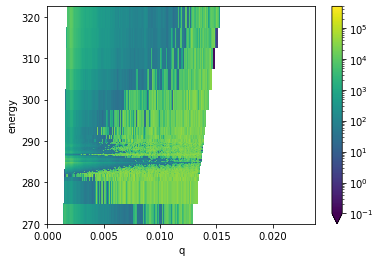

In [22]:
from matplotlib.colors import LogNorm
pol100chi0.plot(norm=LogNorm(1e-1,5e5))

For fitting, we can use the xarray split-apply-combine paradigm to automate things nicely.
Skipping the array prep for now, but here is the syntax.  This part is very much work in progress.

In [145]:
import Fitting
from Fitting import fit_lorentz_bg

In [277]:
lor0p002_p100_e0p1_chi0 = (pol100e0p1
       .coarsen(chi=10).mean()      #you can either coarsen chi (where number is an integer number of bins
                                     #over which to do a moving average), or
       #.sel(chi=0,method='nearest')  #you can just select a single chi stripe, if you do this, you can't stack
       .stack(echi=['energy','chi']) 
       .sel(q=slice(0.0018,0.0025))
       .groupby('echi')
       .map(fit_lorentz_bg,guess=[0,0,0.0002,2e-8],pos_int_override=True)
       .unstack('echi'))
lor0p002_p100_e0p1_chim90 = (pol100e0p1
       #.coarsen(chi=15).mean()      #you can either coarsen chi (where number is an integer number of bins
                                     #over which to do a moving average), or
       .sel(chi=-90,method='nearest')  #you can just select a single chi stripe, if you do this, you can't stack
       .stack(echi=['energy'])#,'chi'])
       .sel(q=slice(0.0018,0.0025))
       .groupby('echi')
       .map(fit_lorentz,guess=[0,0,0.0002],pos_int_override=True)
       .unstack('echi'))

lor0p002_p100_e0p1_chim90 = (pol100e0p1
       .sel(chi=-90,method='nearest')  #you can just select a single chi stripe, if you do this, you can't stack
       .sel(q=slice(0.0018,0.0025))
       .map(fit_lorentz,guess=[0,0,0.0002],pos_int_override=True)



Starting fit on Coordinates:
    chi      float64 0.483
  * q        (q) float64 0.001839 0.001888 0.001937 ... 0.002426 0.002475
    echi     object (270.0,)
Fit completed, coeff = [5.58710261e-09 2.14143365e-03 1.28799515e-04 4.10084458e-09]
Starting fit on Coordinates:
    chi      float64 0.483
  * q        (q) float64 0.001839 0.001888 0.001937 ... 0.002426 0.002475
    echi     object (280.0,)
Fit completed, coeff = [1.22653626e-09 2.14293984e-03 1.36948357e-04 5.79321512e-10]
Starting fit on Coordinates:
    chi      float64 0.483
  * q        (q) float64 0.001839 0.001888 0.001937 ... 0.002426 0.002475
    echi     object (281.0,)
Fit completed, coeff = [5.35843435e-10 2.19031094e-03 1.05557154e-04 2.52267420e-10]
Starting fit on Coordinates:
    chi      float64 0.483
  * q        (q) float64 0.001839 0.001888 0.001937 ... 0.002426 0.002475
    echi     object (282.0,)
Fit completed, coeff = [ 2.63434223e-10  2.10201348e-03  5.36061360e-04 -1.38503819e-10]
Starting fit on Coor